In [2]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cmasher as cmr

import numpy as np

import copy

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import pickle

In [3]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [4]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']


stream='GD-1'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-100,20]

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])] # clunky to hard code this

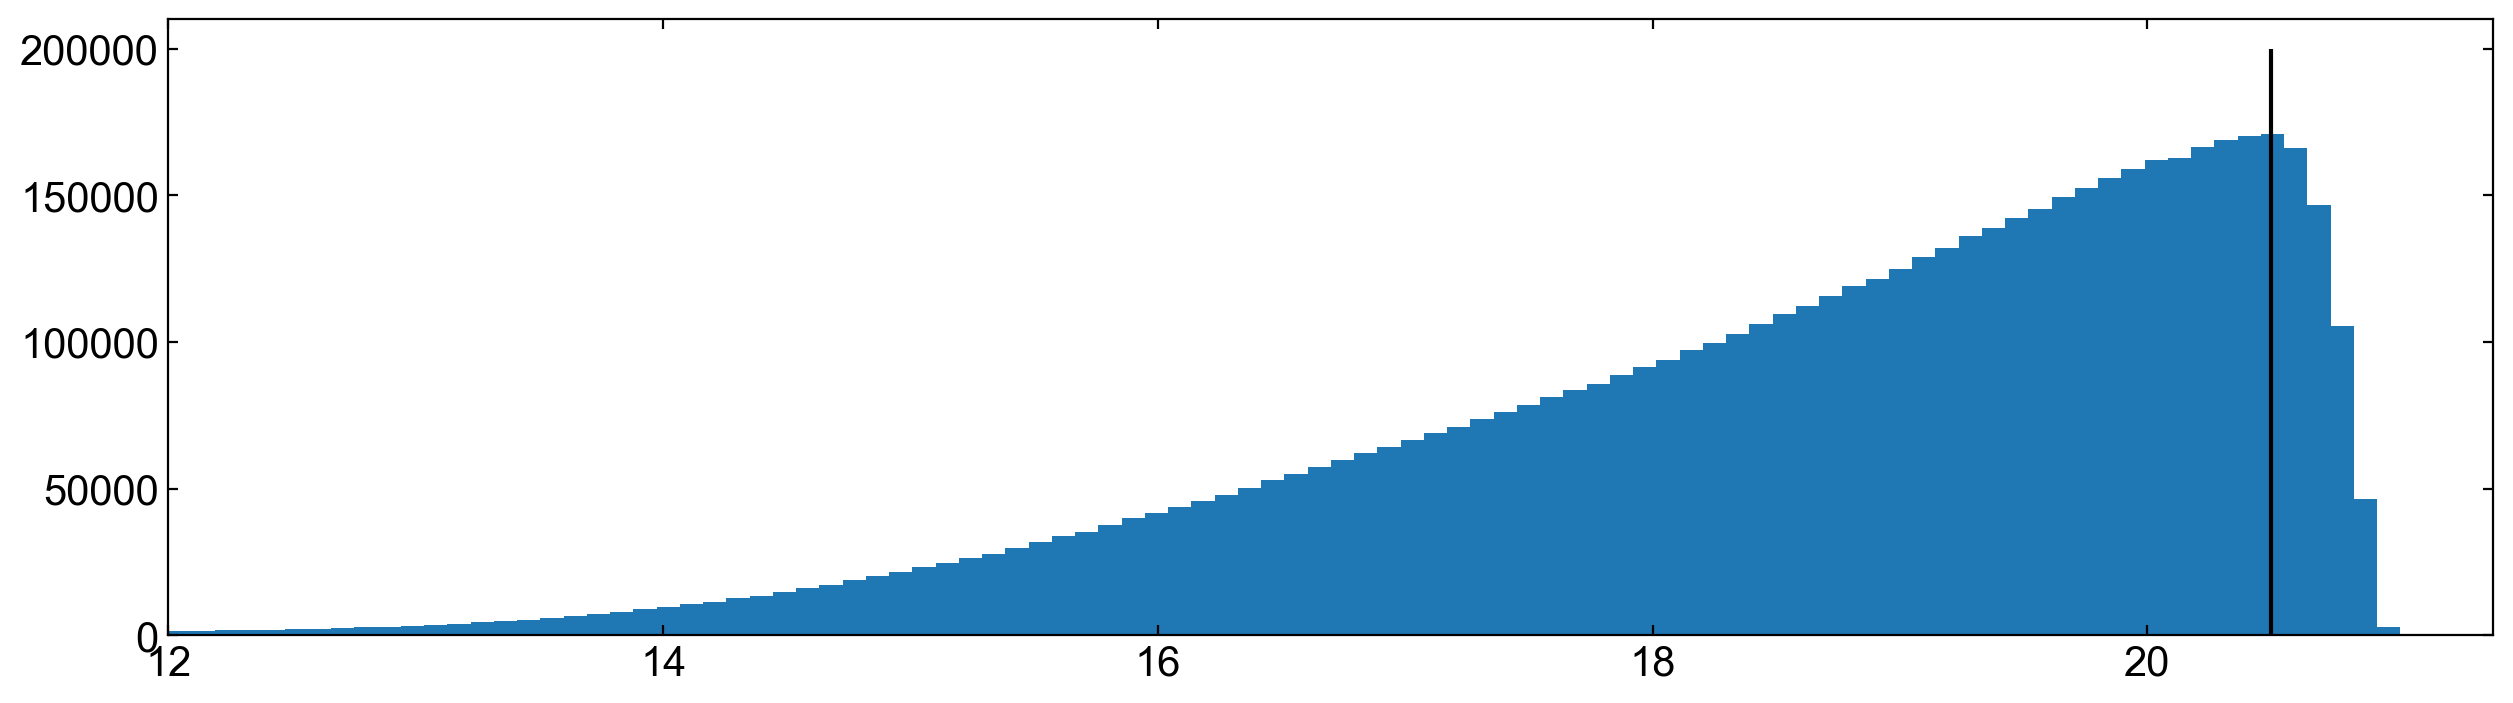

In [5]:
plt.figure(figsize=(15,4))
plt.hist(data['phot_g_mean_mag'], bins=100, range=[12,21.4])
plt.vlines(20.5, 0, 200000, color='k')
plt.xlim(12, 21.4)
plt.show()

In [6]:
p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.2765824411502, -3.1631661457594973, 0.4018776191208751, 0.5346353001205577] 

Producing the polygon and mask


In [7]:
Base.setup(p, cat)

run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [8]:
Base.coord_bounds

{'phi1': (-99.99999968177843, 19.999977507814812),
 'phi2': (-7.970665258306633, 3.3488445561550395),
 'pm1': (-15.099955792705842, -4.636272829387963),
 'pm2': (-5.417437266355175, 1.929407661299365)}

In [9]:
with open('../data/mix_opt_params.pkl', 'rb') as input_file_:
        mix_params = pickle.load(input_file_)

sep = 'small'

if sep == 'xsmall':
    knot_sep = 5
    dens_steps = np.array([2, 0.2]) #xsmall, goes with knot_step=5
    with open('../data/full_model_opt_params_xsmall_sep.pkl', 'rb') as input_file:
        params = pickle.load(input_file)
elif sep == 'small':
    knot_sep = 10
    dens_steps = np.array([4, 0.4]) #small, goes with knot_step=10
    with open('../data/full_model_opt_params_small_sep.pkl', 'rb') as input_file:
        params = pickle.load(input_file)
elif sep == 'medium':
    knot_sep = 15
    dens_steps = np.array([6, 0.6]) #medium, goes with knot_step=15
    with open('../data/full_model_opt_params_medium_sep.pkl', 'rb') as input_file:
        params = pickle.load(input_file)
        
elif sep == 'large':
    knot_sep = 20
    dens_steps = np.array([8, 0.8]) #large, goes with knot_step=20
    with open('../data/full_model_opt_params_large_sep.pkl', 'rb') as input_file:
        params = pickle.load(input_file)

In [10]:
BackgroundModel.bkg_update(pawprint=p, data=cat, knot_sep=knot_sep)
StreamDensModel.stream_dens_update(pawprint=p, data=cat, knot_sep=knot_sep)
OffTrackModel.offtrack_update(pawprint=p, data=cat, dens_steps=dens_steps)

# Model without offtrack
Basic_Components_no_off = [StreamDensModel, BackgroundModel]
stream_opt_no_off = StreamDensModel(mix_params['stream'])
mix_opt_no_off = StreamMixtureModel(mix_params, Components=Basic_Components_no_off)


# different parts of full model
background_opt = BackgroundModel(params['background'])
stream_opt = StreamDensModel(params['stream'])
offtrack_opt = OffTrackModel(params['offtrack'])

Basic_Components = [StreamDensModel, BackgroundModel]
mix_opt = StreamMixtureModel(params, Components=Basic_Components)

No_Bkg_Comp = [StreamDensModel, OffTrackModel]
full_mix_nobkg_opt = StreamMixtureModel(params, Components=No_Bkg_Comp)

full_Components = [StreamDensModel, BackgroundModel, OffTrackModel]
full_mix_opt = StreamMixtureModel(params, Components=full_Components)

In [27]:
params['offtrack']

{'ln_N': Array(6.6226754, dtype=float32),
 ('phi1',
  'phi2'): {'zs': Array([-3.3042634e+00, -2.8434906e+00, -8.4488040e-01,  4.7838497e-01,
         -1.5603410e+00, -3.0120525e+00, -3.6520529e+00, -3.8859608e+00,
         -3.7966802e+00, -3.3631182e+00, -2.9927106e+00, -3.3730433e+00,
         -3.7689178e+00, -3.9267423e+00, -3.8317285e+00, -2.9000852e+00,
          6.2721550e-01, -2.3024528e+00, -2.9196894e+00, -2.4684153e+00,
          8.4653920e-01,  7.3219967e-01, -3.0023949e+00, -3.7224116e+00,
         -3.9696553e+00, -3.9842157e+00, -3.5262959e+00,  3.0451447e-01,
         -1.8244941e+00,  1.5887538e+00, -1.5535119e+00, -1.8273659e+00,
         -2.4708724e+00, -2.7198839e+00, -3.0555623e+00, -3.4432206e+00,
         -3.7022495e+00, -3.5437288e+00, -2.7917693e+00, -2.7958068e-01,
          1.7337877e-01, -3.0534964e+00, -3.6524408e+00, -3.7063575e+00,
         -3.2230732e+00, -1.6470195e+00, -1.0385674e+00, -2.0641451e+00,
         -2.2195754e+00, -2.1575153e+00, -2.3434365e+00,

In [34]:
np.mean(pm1_width(phi1s))

0.29236994977182457

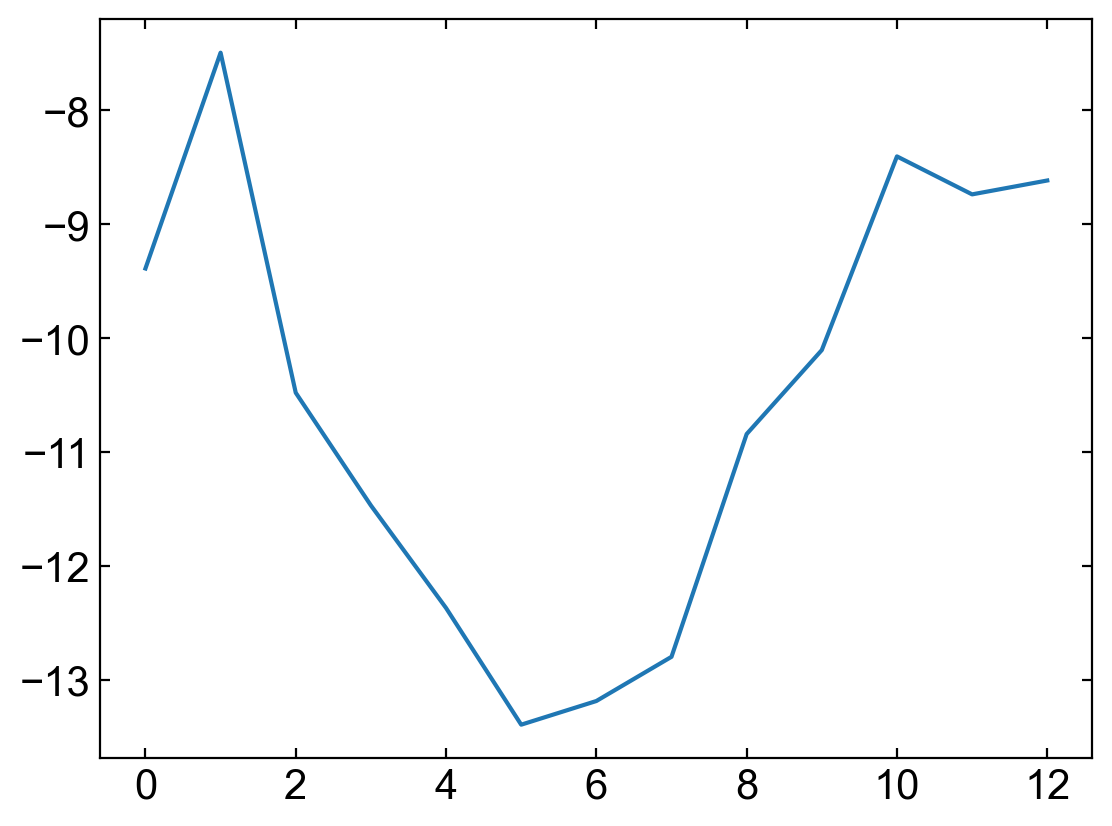

In [31]:
plt.plot(params['offtrack']['pm1']['mean'])

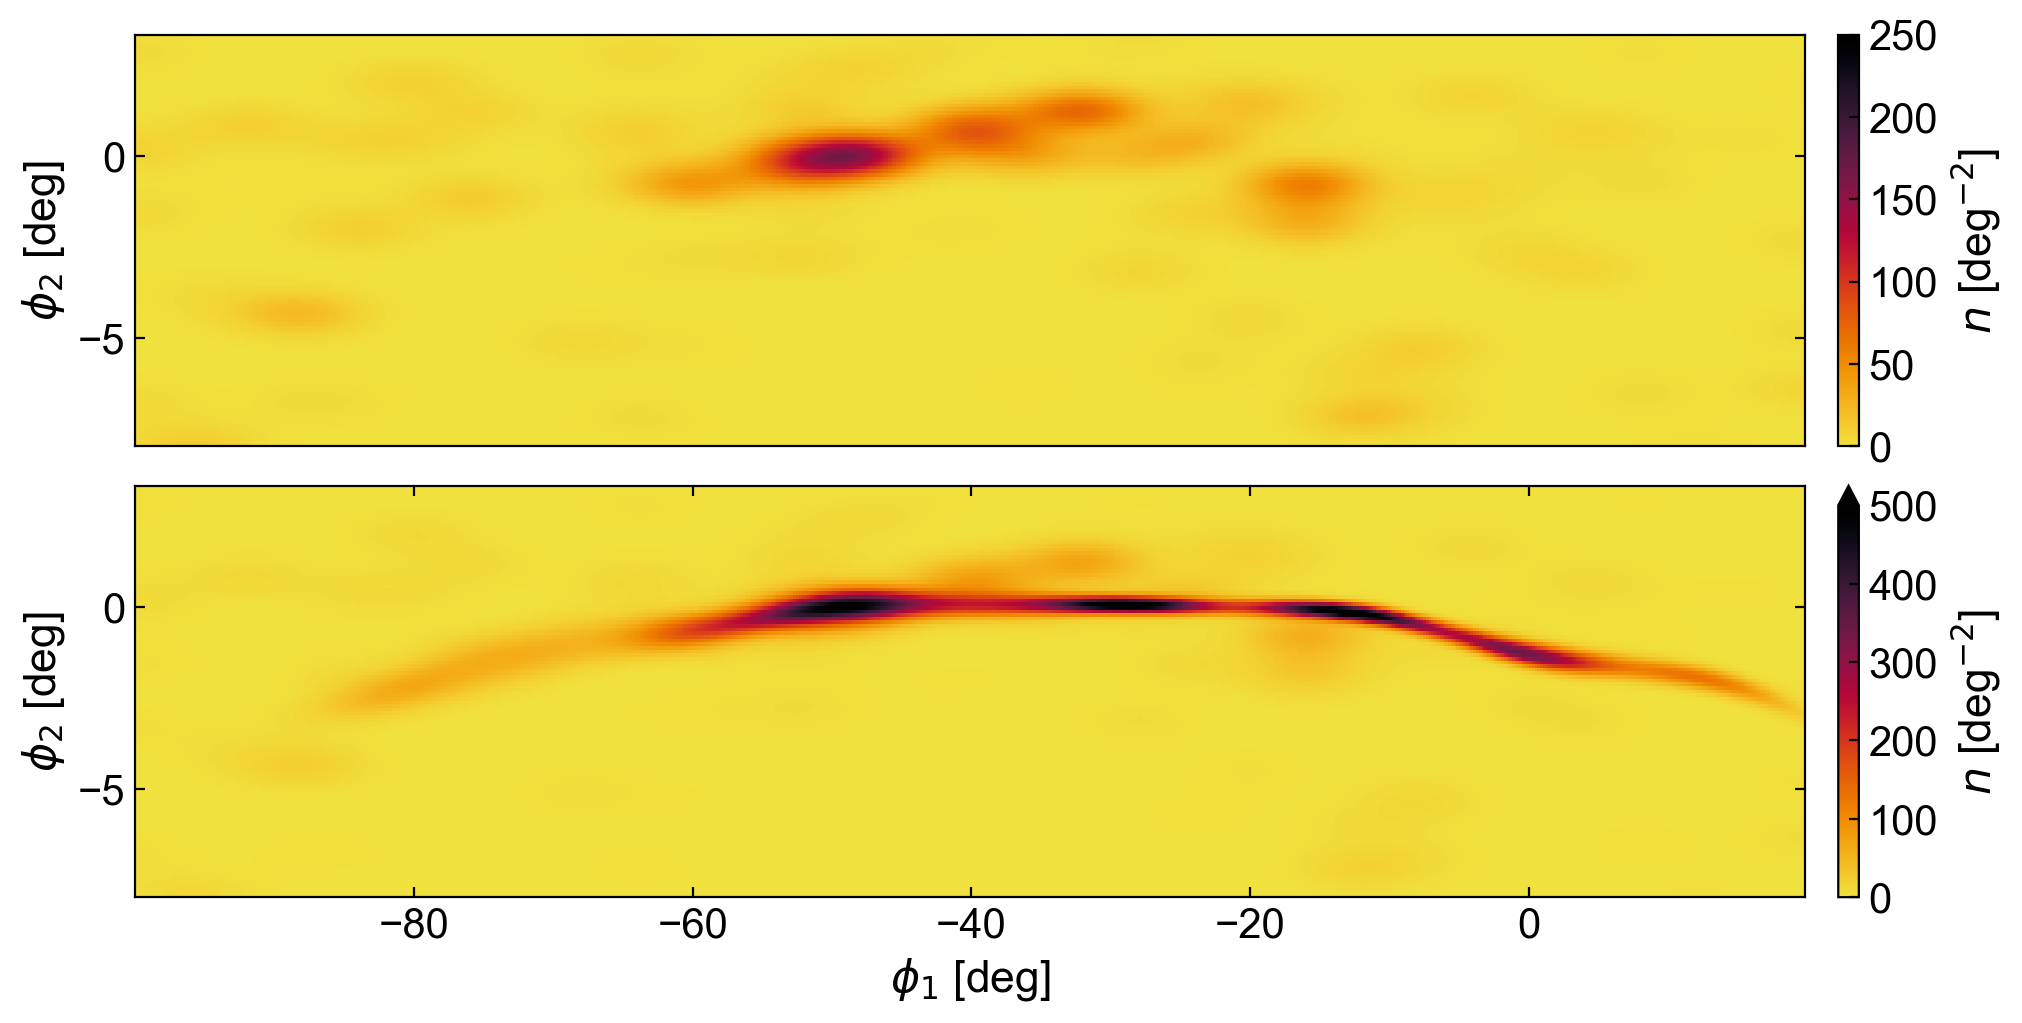

In [11]:
tmp_pars = copy.deepcopy(params['offtrack'])
tmp_pars['pm1'] = params['stream']['pm1'].copy()
tmp_pars['pm2'] = params['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True)
_, _, pcms = tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], axes=ax1, label=True, 
    pcolormesh_kwargs=dict(vmin=0, vmax=0.5, cmap=cmr.ember_r, rasterized=True)
)
cbar1 = fig.colorbar(pcms[0], ax=ax1, ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], pad=0.02,
           format=mticker.FixedFormatter(['0', '50', '100', '150', '200', '250']))


ax1.xaxis.set_visible(False)

_, _, pcms2 = full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], axes=ax2, 
    pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap=cmr.ember_r, rasterized=True))
cbar2 = fig.colorbar(pcms2[0], ax=ax2, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], pad=0.02,
           format=mticker.FixedFormatter(['0', '100', '200', '300', '400', '500']), extend='max')

#combined colorbar (if we want the same one
#cbar = fig.colorbar(pcms2[0], ax=[ax1,ax2], ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
#            format=mticker.FixedFormatter(['0', '50', '100', '150', '200', '250']), extend='max')
cbar1.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)


plt.savefig('../paper_figures/offtrack_model.pdf')
plt.show()

### Make Linear Density Plot

In [12]:
grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(grid_coord_names=[("phi1", "phi2")])

In [13]:
stream_lin_dens = np.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0)
off_lin_dens = np.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0)
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1


phi2_track = IUS(stream_opt.phi2_knots, params['stream']['phi2']['mean'])
phi2_width = IUS(stream_opt.phi2_knots, np.exp(params['stream']['phi2']['ln_std']))
pm1_track = IUS(stream_opt.pm1_knots, params['stream']['pm1']['mean'])
pm1_width = IUS(stream_opt.pm1_knots, np.exp(params['stream']['pm1']['ln_std']))
pm2_track = IUS(stream_opt.pm2_knots, params['stream']['pm2']['mean'])
pm2_width = IUS(stream_opt.pm2_knots, np.exp(params['stream']['pm2']['ln_std']))


phi2_track_no_off = IUS(stream_opt_no_off.phi2_knots, mix_params['stream']['phi2']['mean'])
phi2_width_no_off = IUS(stream_opt_no_off.phi2_knots, np.exp(mix_params['stream']['phi2']['ln_std']))
pm1_track_no_off = IUS(stream_opt_no_off.pm1_knots, mix_params['stream']['pm1']['mean'])
pm1_width_no_off = IUS(stream_opt_no_off.pm1_knots, np.exp(mix_params['stream']['pm1']['ln_std']))
pm2_track_no_off = IUS(stream_opt_no_off.pm2_knots, mix_params['stream']['pm2']['mean'])
pm2_width_no_off = IUS(stream_opt_no_off.pm2_knots, np.exp(mix_params['stream']['pm2']['ln_std']))

In [14]:
phi1s[500]

0.10000031822299035

In [15]:
print(np.median((stream_lin_dens+off_lin_dens)[200:525]))

4.461286


In [16]:
print(np.median((stream_lin_dens+off_lin_dens)[50:175]))
print(np.median((stream_lin_dens+off_lin_dens)[525:]))

1.7088618
1.5853331


In [17]:
4.46/1.66

2.6867469879518073

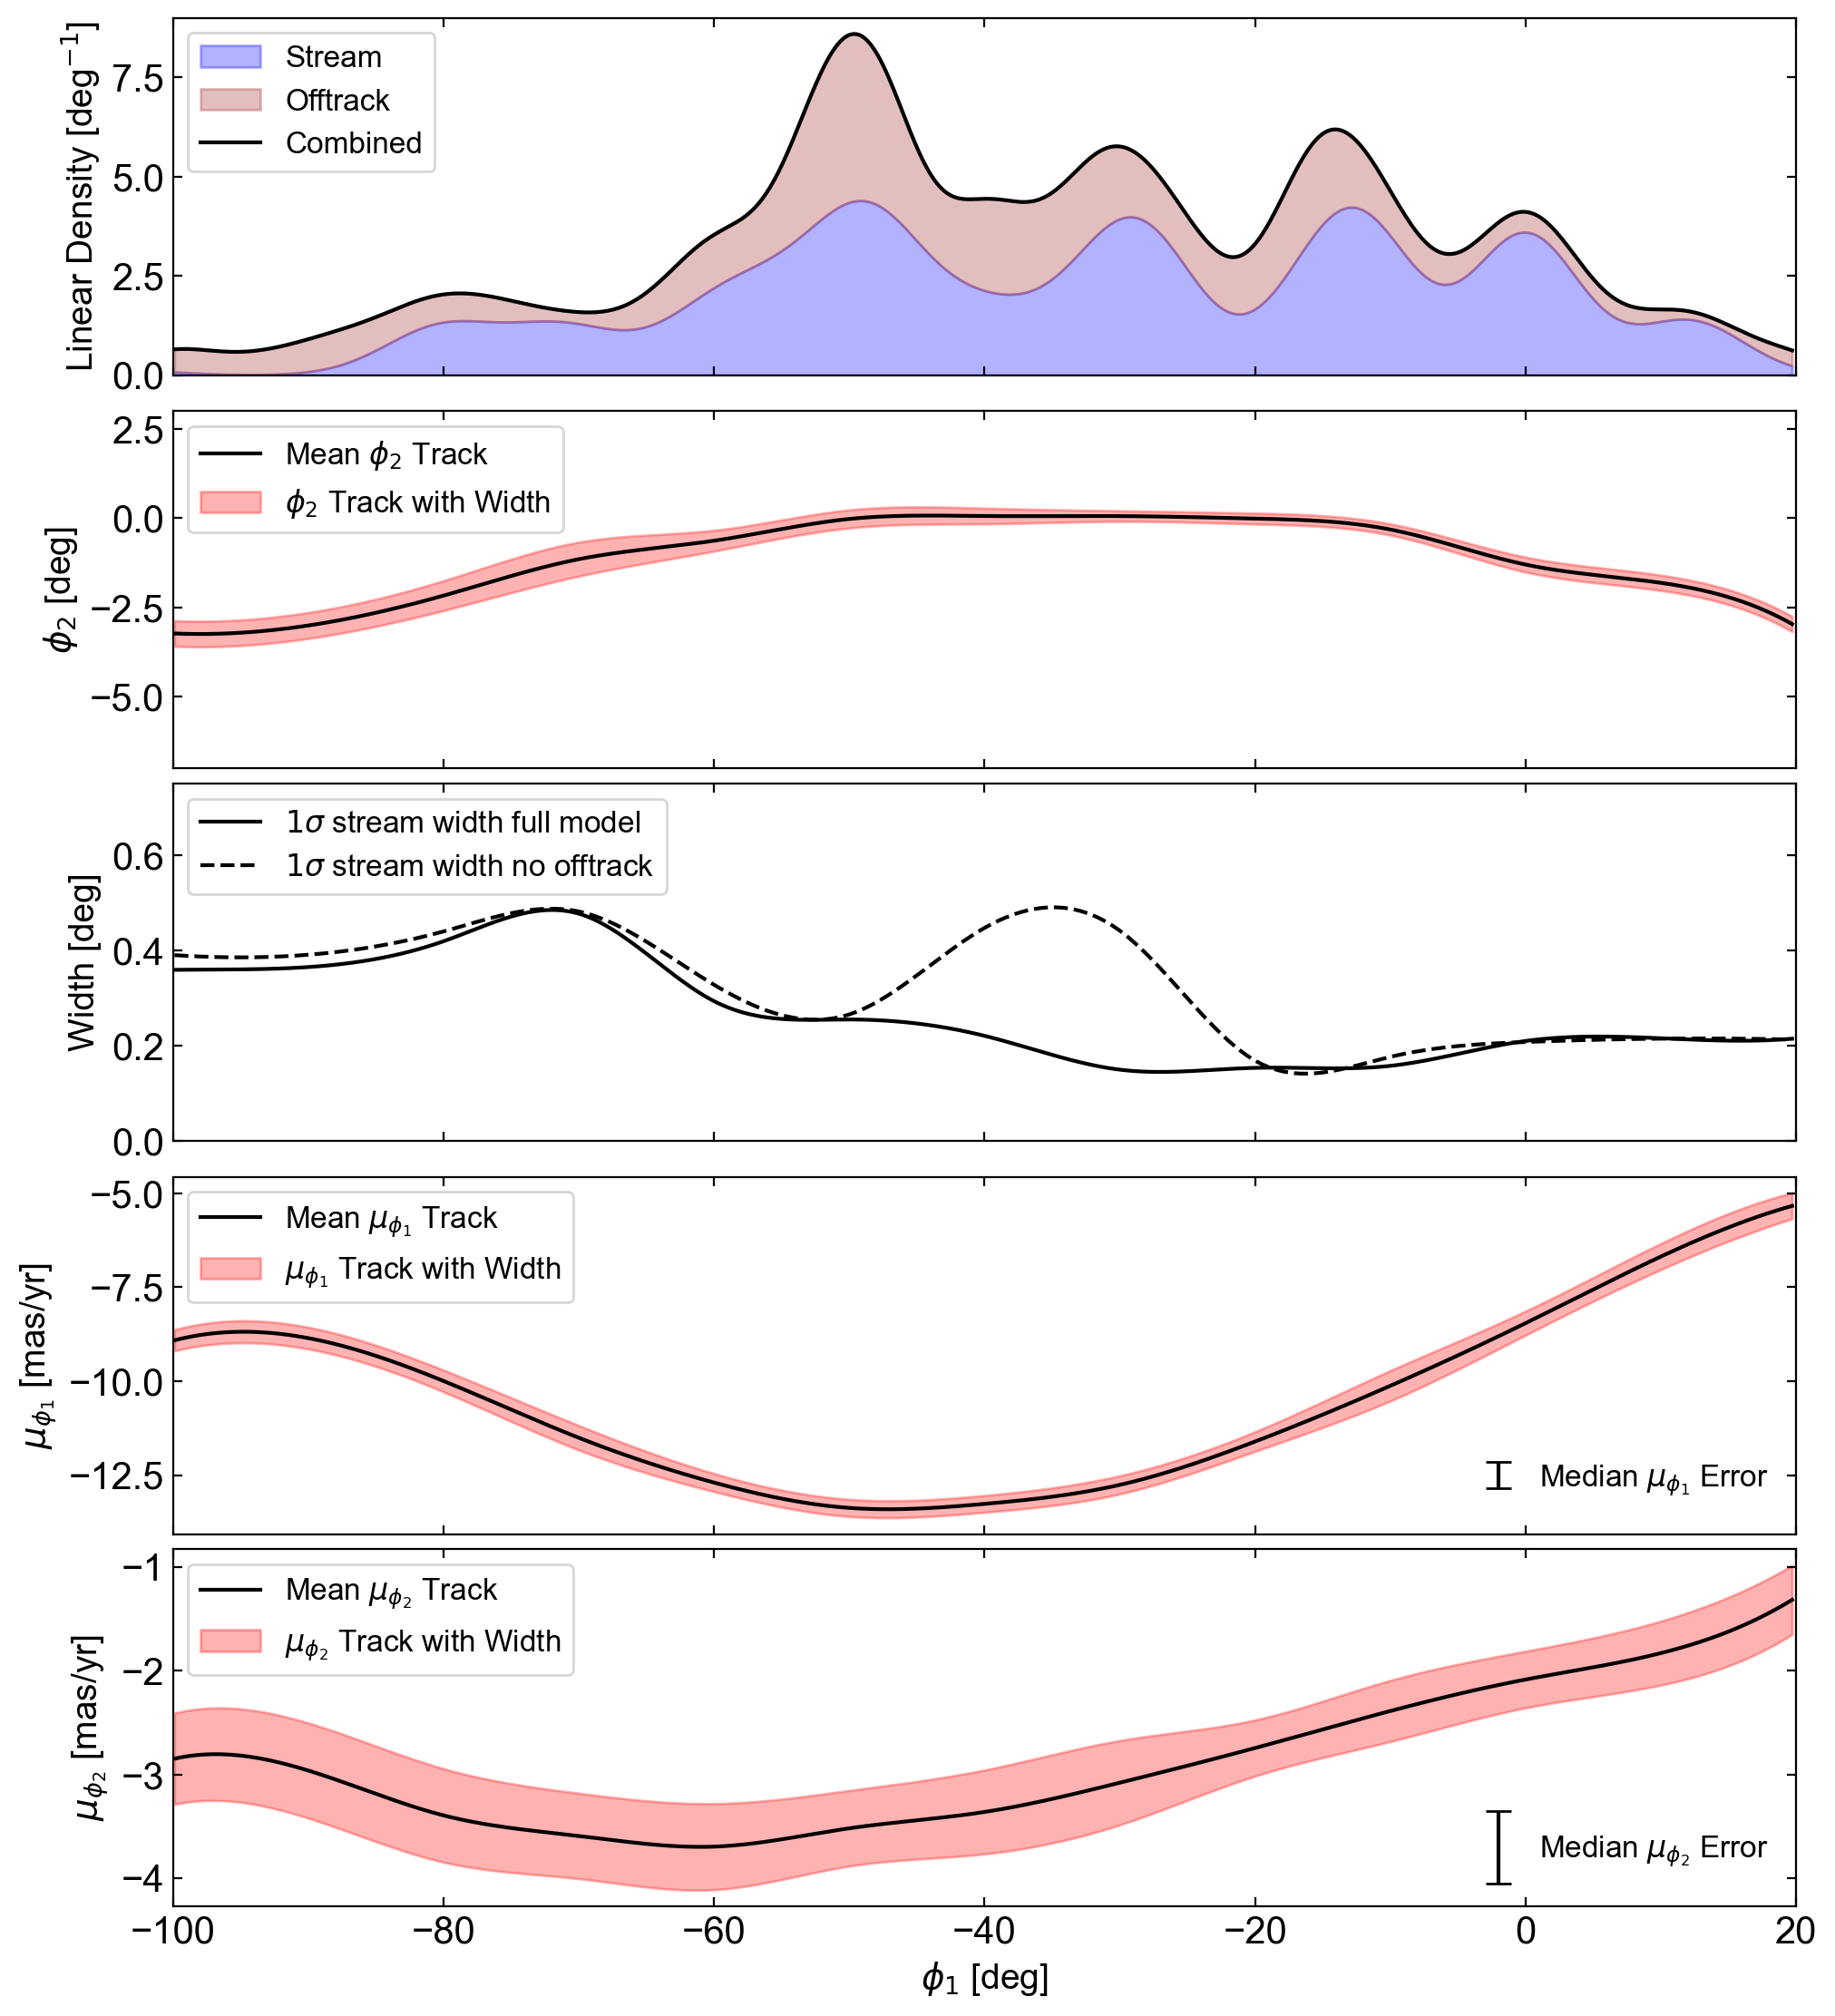

In [18]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'Stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='brown', alpha=0.3, label=r'Offtrack')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'Combined')
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,9)
ax1.legend(fontsize=12, loc='upper left')

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'Mean $\phi_2$ Track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\phi_2$ Track with Width')
# ax2.fill_between(phi1s, phi2_track_no_off(phi1s) - phi2_width_no_off(phi1s), 
#                  phi2_track_no_off(phi1s) + phi2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ Track with Width')
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
ax3.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no offtrack')
ax3.set_ylim(0, 0.75)
ax3.set_ylabel(r'Width [deg]', fontsize=14)
ax3.legend(fontsize=12, loc='upper left')

ax4.plot(phi1s, pm1_track(phi1s), c='k', label=r'Mean $\mu_{\phi_1}$ Track')
ax4.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -12.8, r'Median $\mu_{\phi_1}$ Error', fontsize=12)
ax4.fill_between(phi1s, pm1_track(phi1s) - pm1_width(phi1s), pm1_track(phi1s) + pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
# ax4.fill_between(phi1s, pm1_track_no_off(phi1s) - pm1_width_no_off(phi1s), 
#                  pm1_track_no_off(phi1s) + pm1_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
ax4.set_ylabel(r'$\mu_{\phi_1}$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left')

ax5.plot(phi1s, pm2_track(phi1s), c='k', label=r'Mean $\mu_{\phi_2}$ Track')
ax5.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax5.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, pm2_track(phi1s) - pm2_width(phi1s), pm2_track(phi1s) + pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
# ax5.fill_between(phi1s, pm2_track_no_off(phi1s) - pm2_width_no_off(phi1s), 
#                  pm2_track_no_off(phi1s) + pm2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
ax5.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]', fontsize=14)
ax5.legend(fontsize=12, loc='upper left')

ax5.set_xlim(-100, 20)
ax5.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

plt.savefig('../paper_figures/stream_properties.pdf')
plt.show()

Could be interesting to show how the track and width change when including the offtrack and how not including it would cause incorrect conclusions

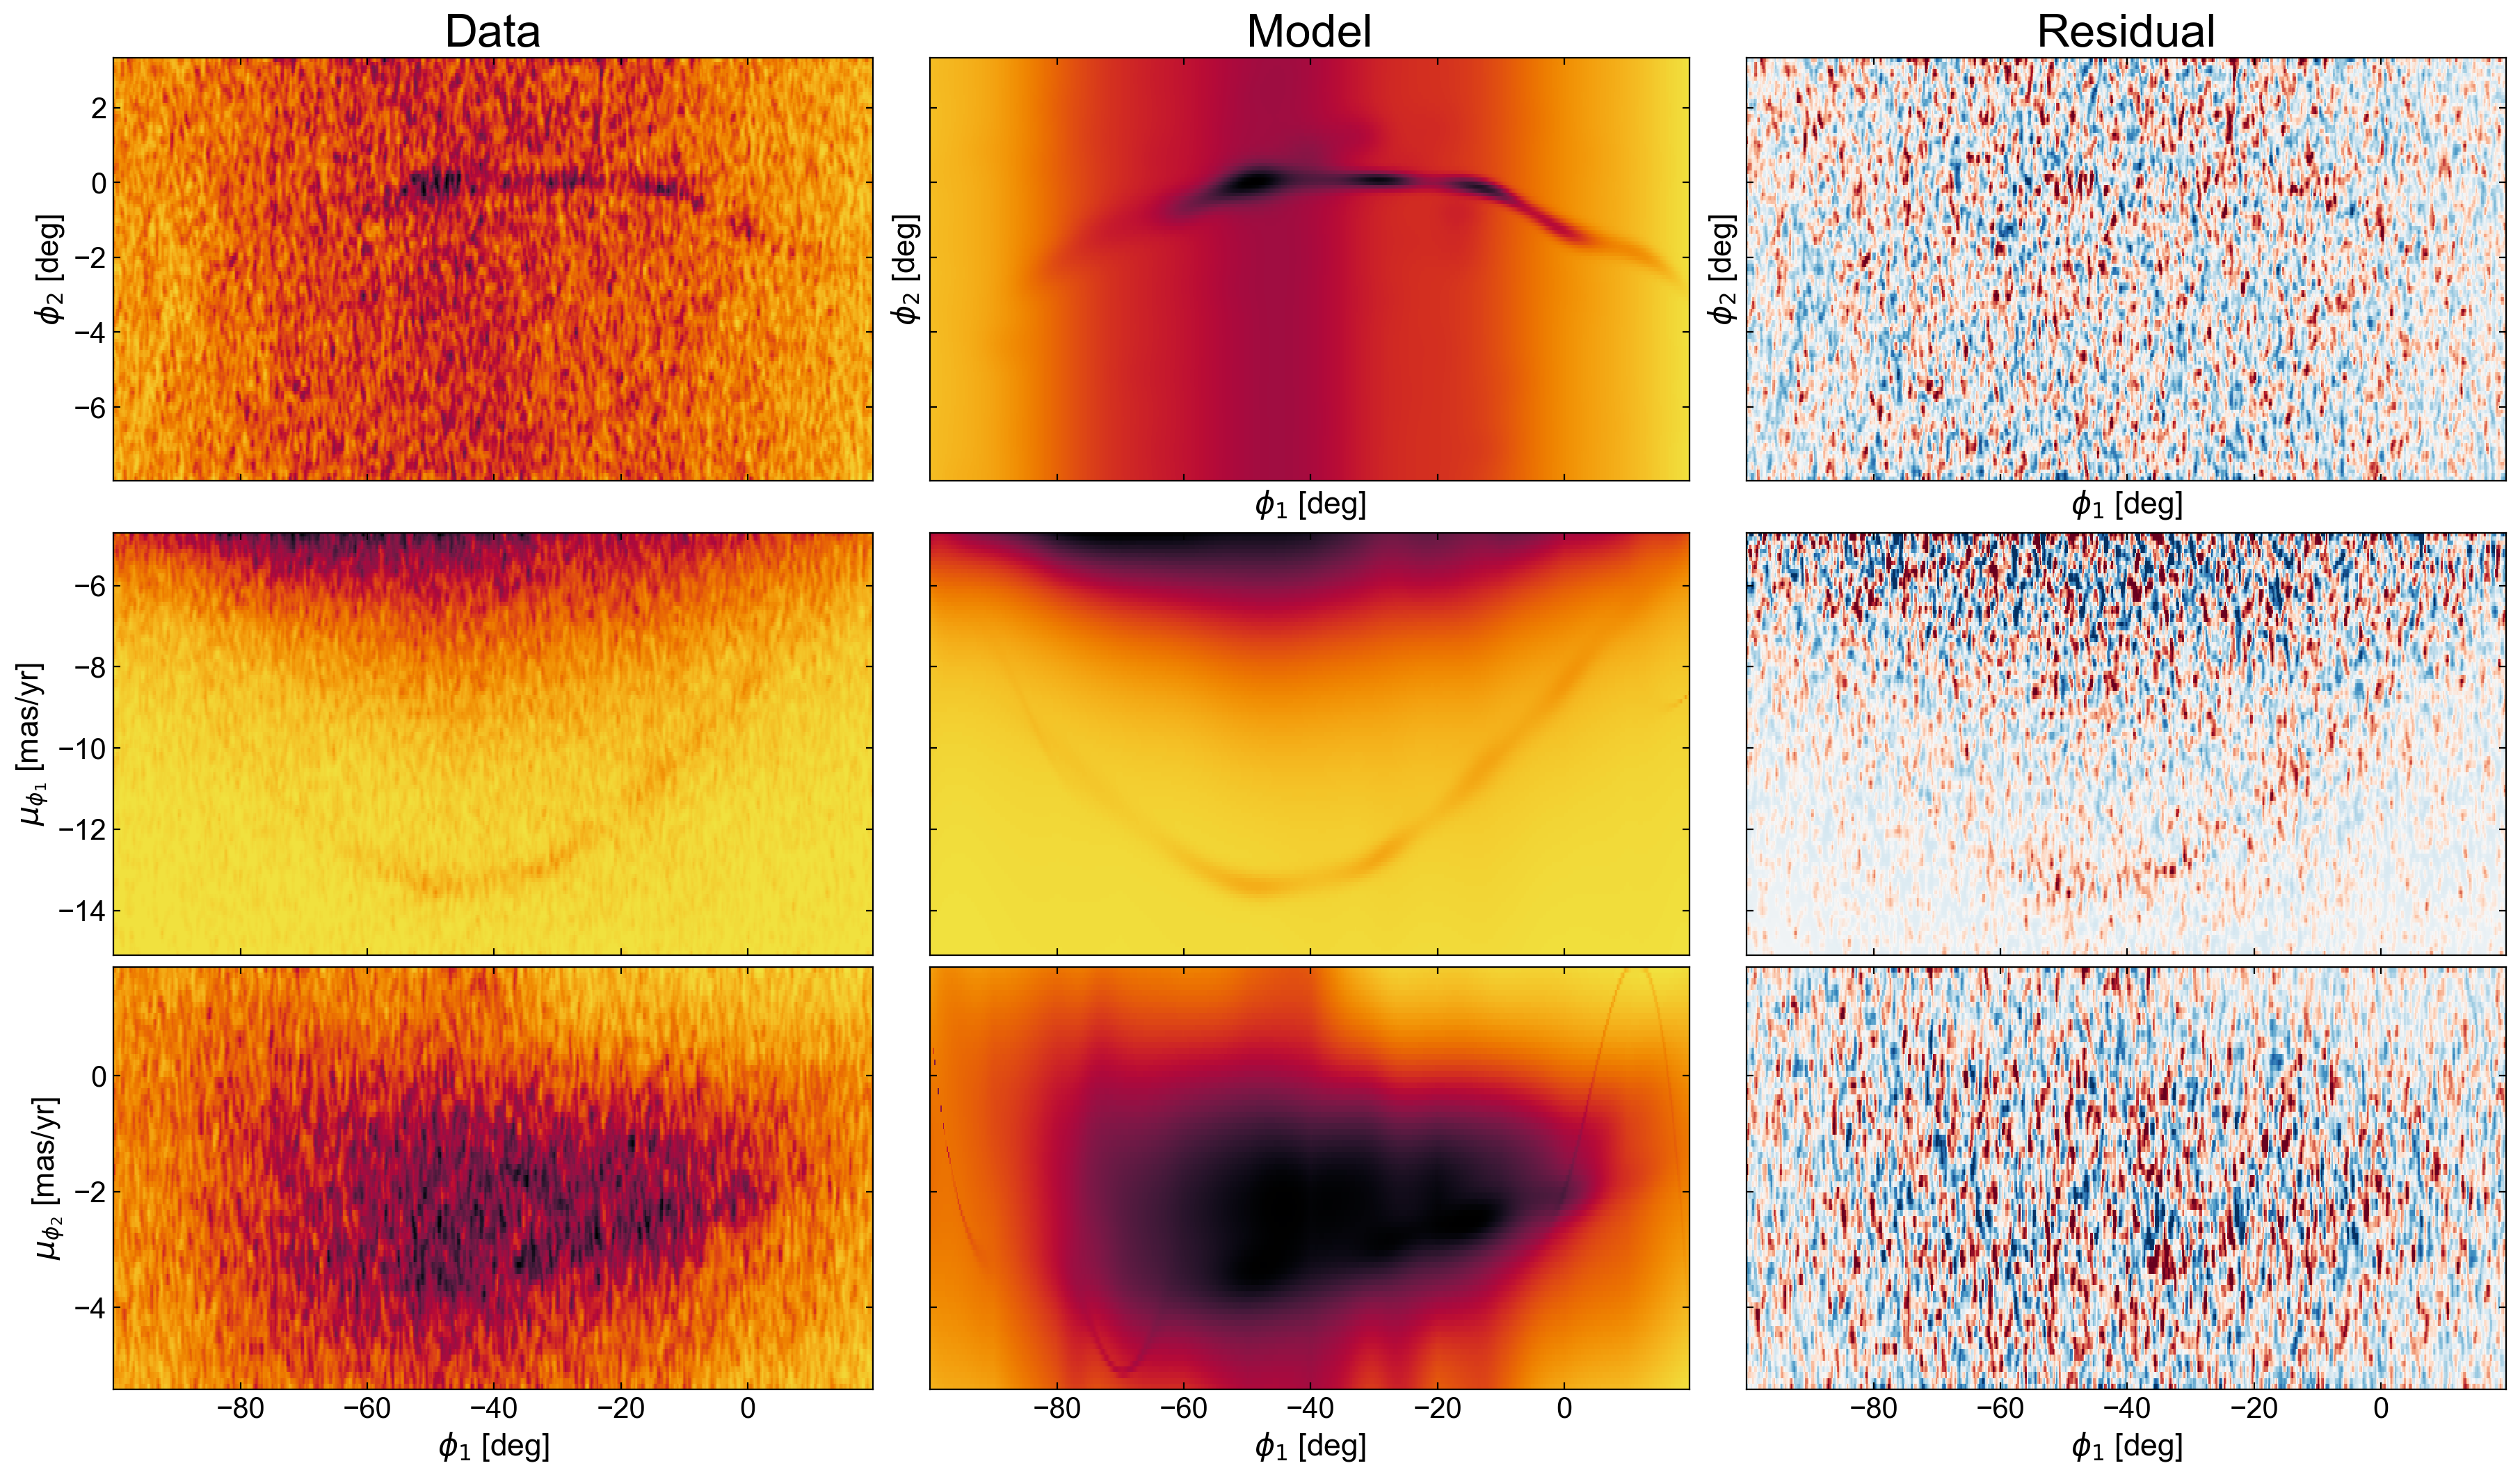

In [20]:
# import importlib
# importlib.reload(sys.modules['stream_membership.plot'])
# importlib.reload(sys.modules['stream_membership.model'])
# importlib.reload(sys.modules['stream_membership'])
# import stream_membership

# full_mix_opt = StreamMixtureModel(params, Components=full_Components)

fig, axes = plt.subplots(
    len(full_mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(full_mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)

full_mix_opt.plot_model_projections(grid_coord_names=[("phi1", "pm1"), ("phi1", "pm2")], axes=axes[1:, 1], label=False,
                              pcolormesh_kwargs=dict(cmap=cmr.ember_r, rasterized=True))
full_mix_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], axes=axes[0,1], 
    pcolormesh_kwargs=dict(cmap=cmr.ember_r, rasterized=True))

full_mix_opt.plot_residual_projections(
    data=run_data, grid_coord_names=[("phi1", "pm1"), ("phi1", "pm2")],
    axes=axes[1:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True))
full_mix_opt.plot_residual_projections(data=run_data,
    grid_coord_names=[("phi1", "phi2")], axes=axes[0,2], 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True))

axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../paper_figures/full_model.pdf')

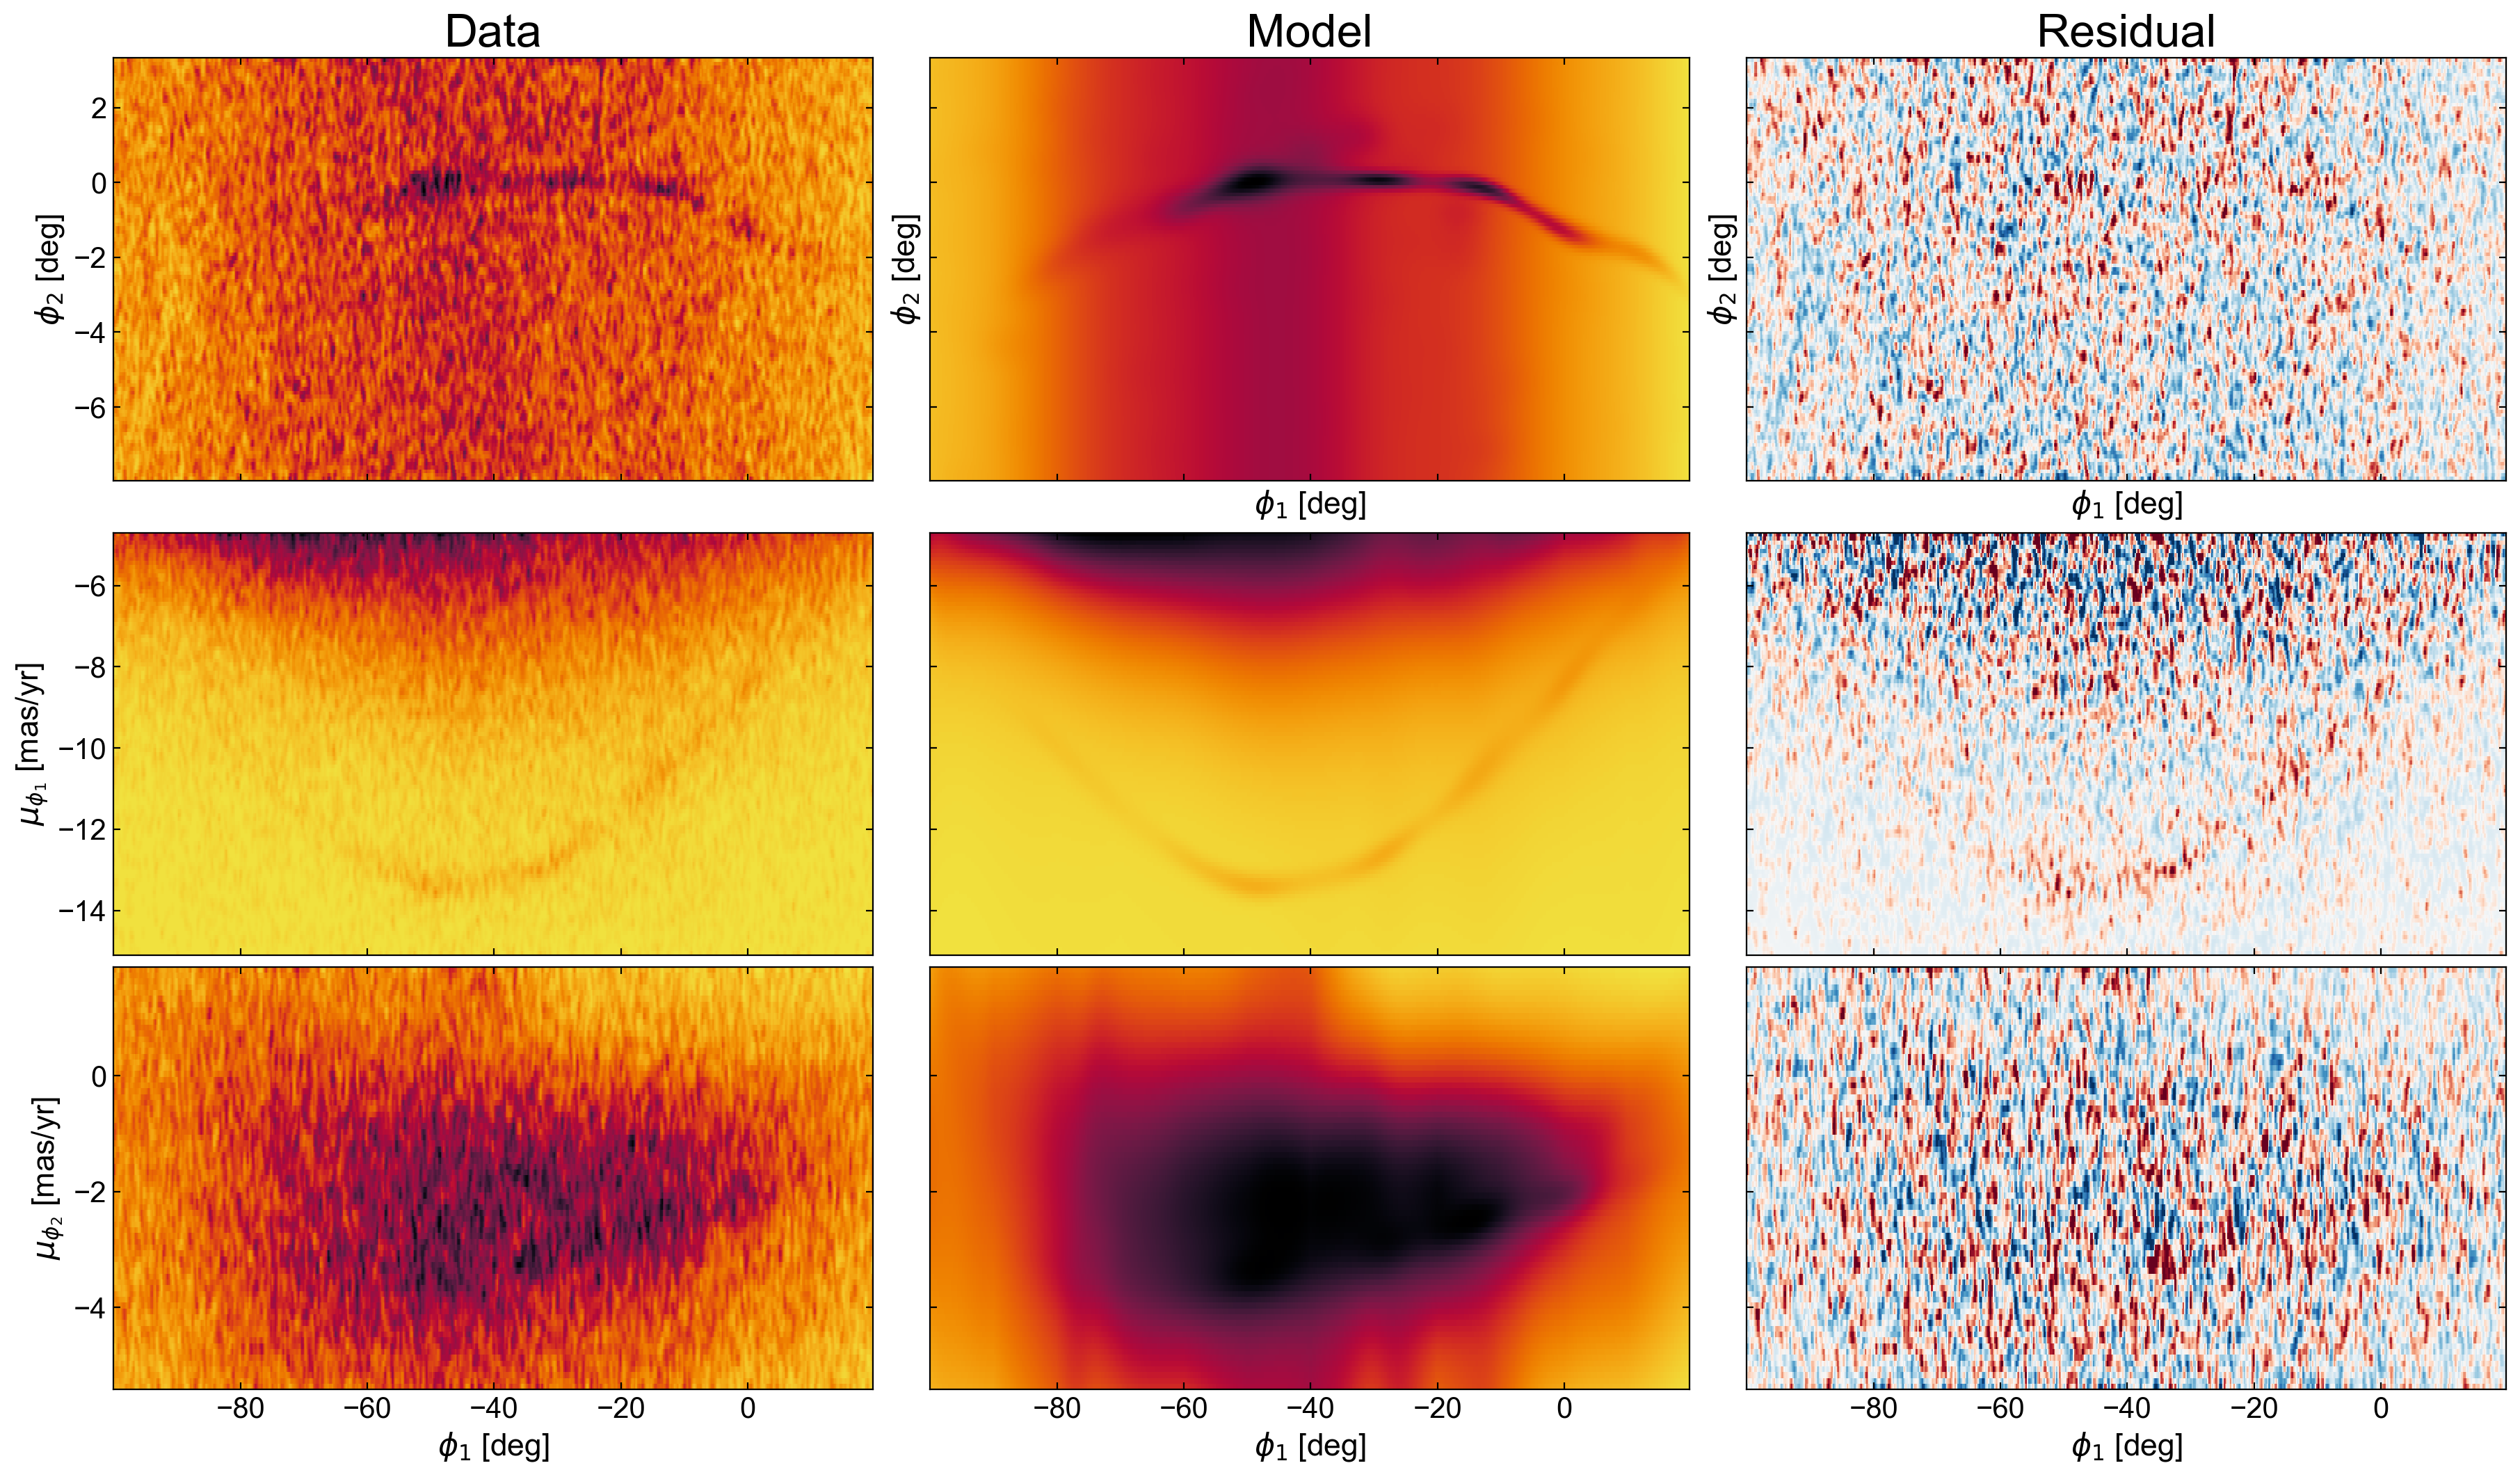

In [21]:
fig, axes = plt.subplots(
    len(full_mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(full_mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)

mix_opt.plot_model_projections(grid_coord_names=[("phi1", "pm1"), ("phi1", "pm2")], axes=axes[1:, 1], label=False,
                              pcolormesh_kwargs=dict(cmap=cmr.ember_r, rasterized=True))
full_mix_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], axes=axes[0,1], 
    pcolormesh_kwargs=dict(cmap=cmr.ember_r, rasterized=True))

mix_opt.plot_residual_projections(
    data=run_data, grid_coord_names=[("phi1", "pm1"), ("phi1", "pm2")],
    axes=axes[1:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True))
full_mix_opt.plot_residual_projections(data=run_data,
    grid_coord_names=[("phi1", "phi2")], axes=axes[0,2], 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True))

axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../paper_figures/full_model.pdf')

In [18]:
most_cat_ = o.cat[pm_mask]
most_cat = {k: np.array(most_cat_[k], dtype="f8") for k in most_cat_.colnames}

In [68]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]

print('Calculating for pawprint output (including CMD cut)...')
stream_ll = stream_comp.ln_number_density(run_data)
bkg_ll = bkg_comp.ln_number_density(run_data)
offtrack_ll = offtrack_comp.ln_number_density(run_data)
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

print('Calculating for all stars in region...')
stream_ll_all = stream_comp.ln_number_density(most_cat)
bkg_ll_all = bkg_comp.ln_number_density(most_cat)
offtrack_ll_all = offtrack_comp.ln_number_density(most_cat)
fg_ll_all = np.logaddexp(stream_ll_all, offtrack_ll_all)

Calculating for pawprint output (including CMD cut)...
Calculating for all stars in region...


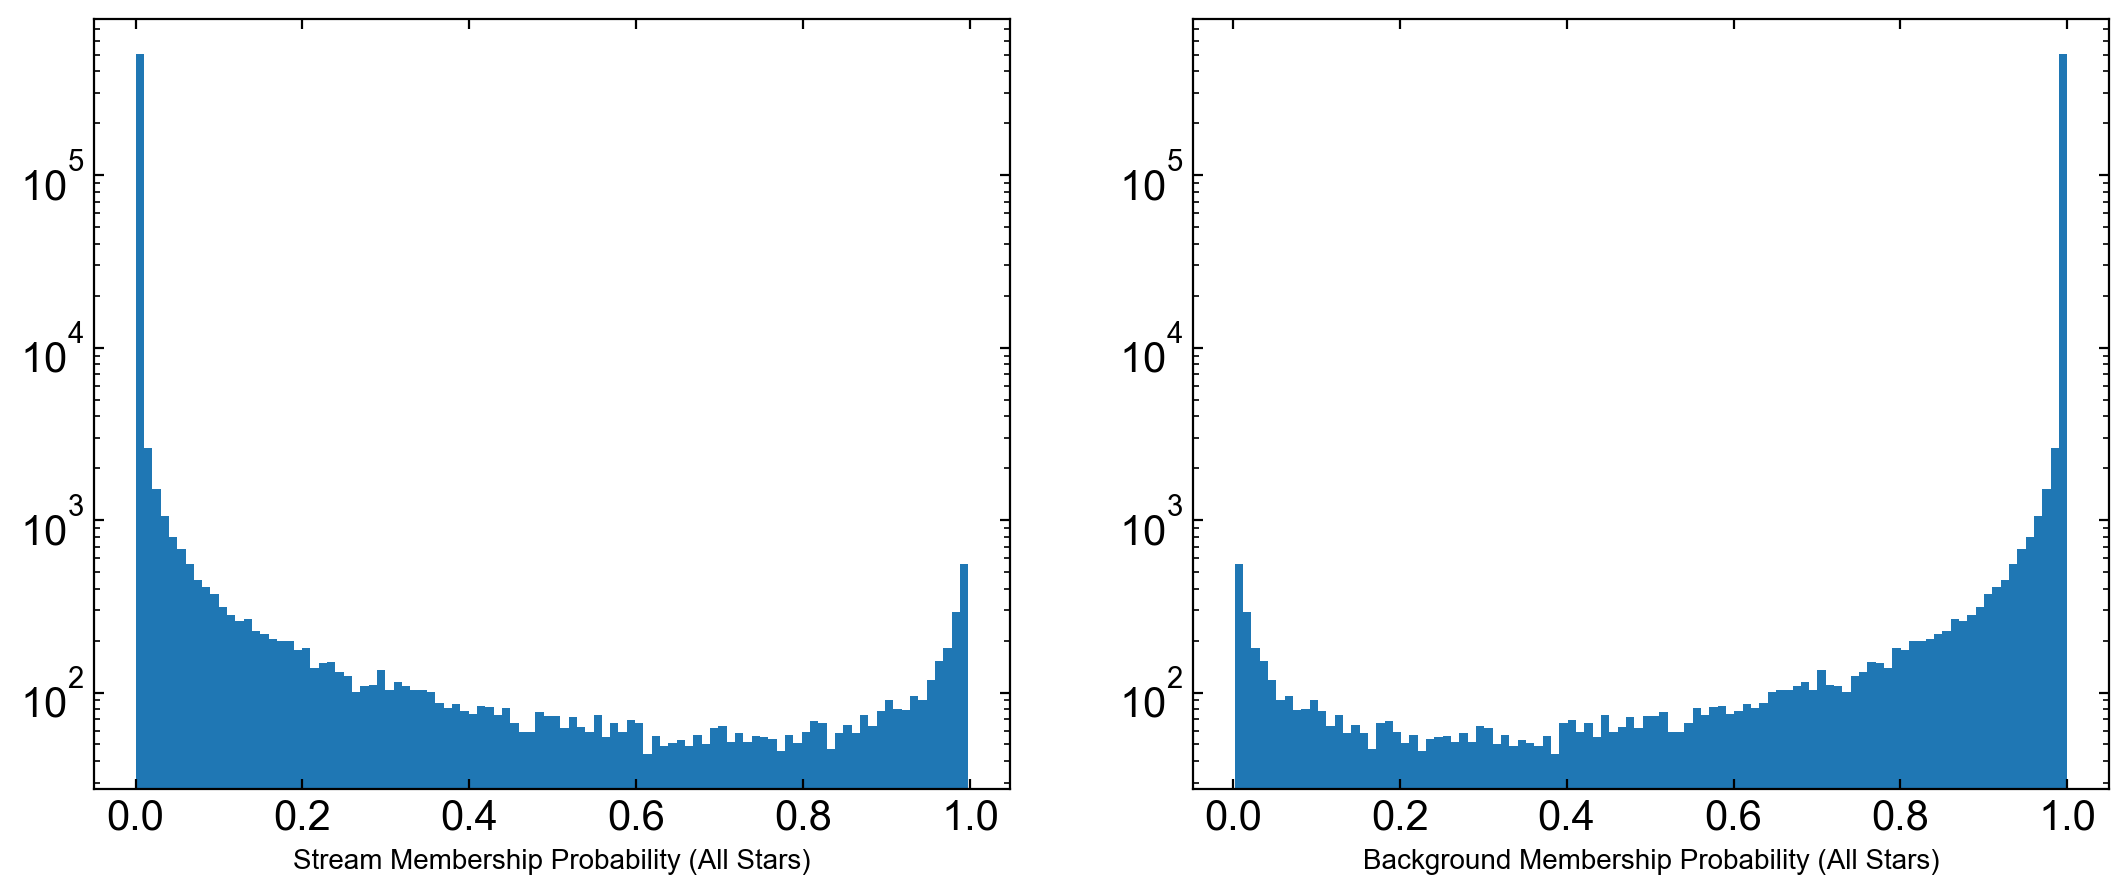

In [69]:
final_memb_prob_all = np.exp(fg_ll_all - np.logaddexp(fg_ll_all,bkg_ll_all)) #update for offtrack included
bkg_prob_all = np.exp(bkg_ll_all - np.logaddexp(fg_ll_all,bkg_ll_all))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob_all, bins=100)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability (All Stars)')

ax2.hist(bkg_prob_all, bins=100)
ax2.set_xlabel('Background Membership Probability (All Stars)')
ax2.set_yscale('log')
plt.show()

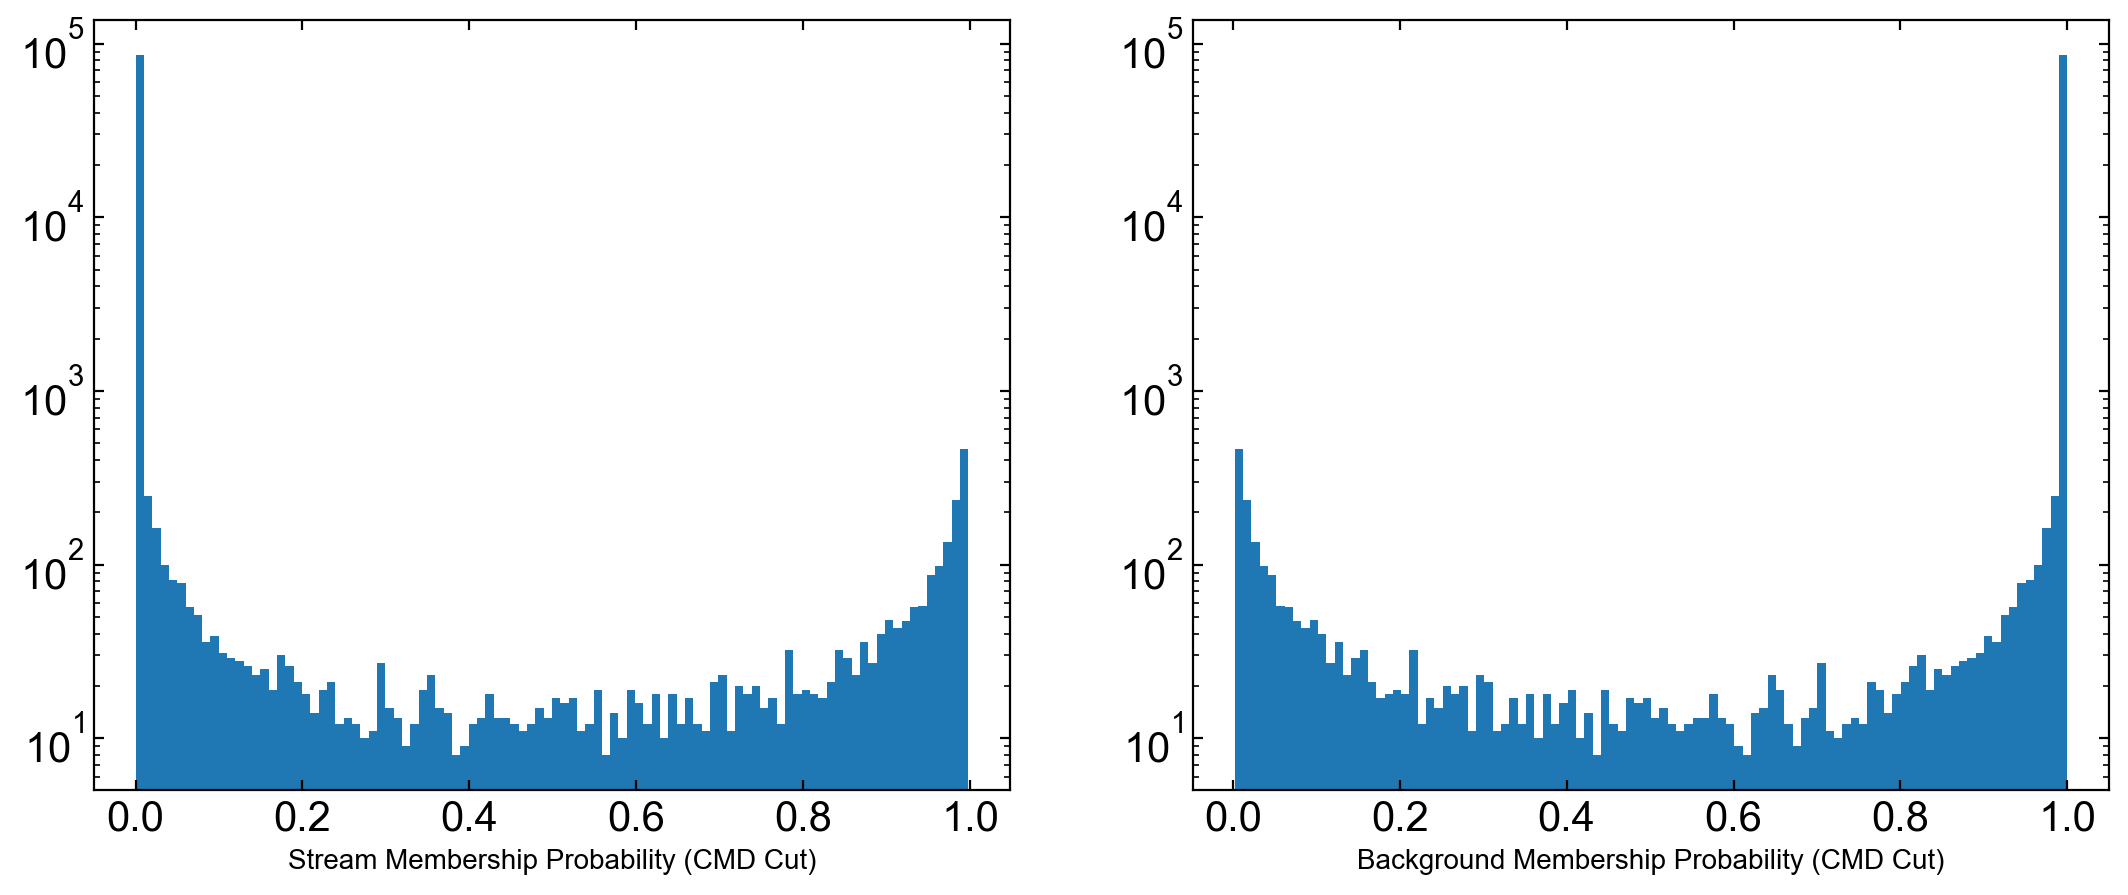

In [70]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=100)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability (CMD Cut)')

ax2.hist(bkg_prob, bins=100)
ax2.set_xlabel('Background Membership Probability (CMD Cut)')
ax2.set_yscale('log')
plt.show()

2008


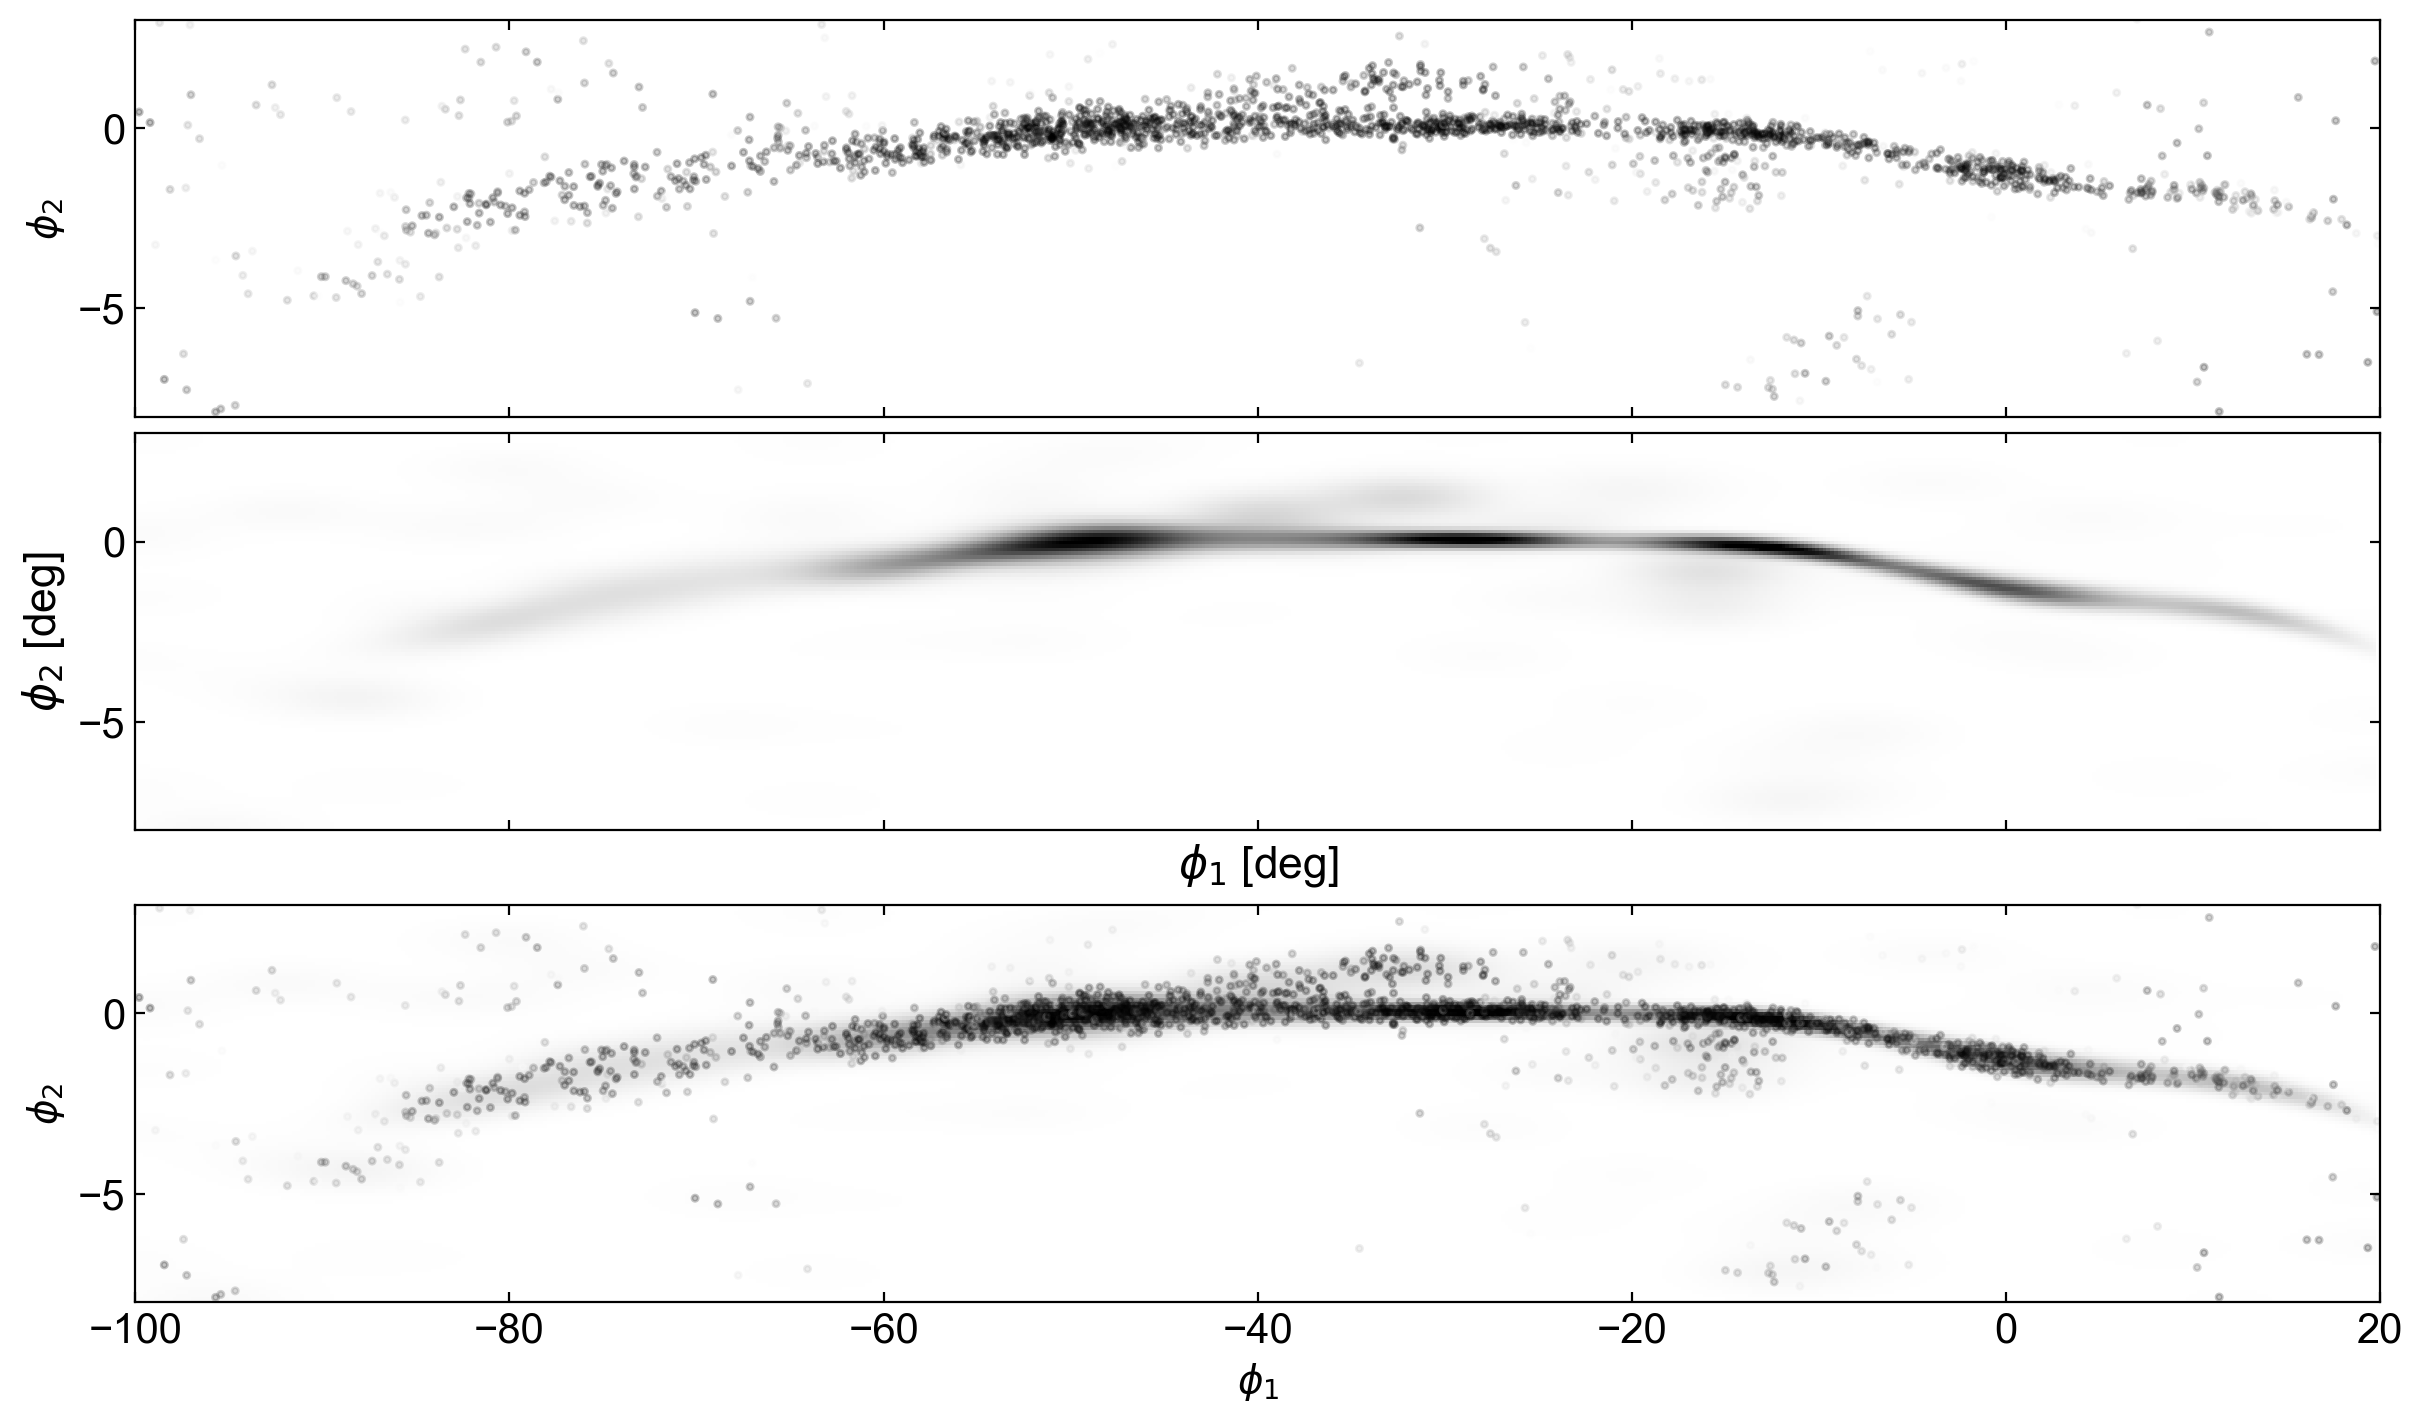

In [71]:
threshold = (final_memb_prob>0.5)
print(threshold.sum())

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[1], axes[2]]:
    _, _, pcms = full_mix_nobkg_opt.plot_model_projections(
        grid_coord_names=[("phi1", "phi2")], axes=ax, label=True, 
        pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap='gray_r', rasterized=True)
    )

for ax in [axes[0], axes[2]]:
    ax.scatter(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        c=final_memb_prob[threshold],
        cmap='gray_r',
        s=5,
        # marker="o",
        # markeredgewidth=0,
        # markersize=3.0,
        # ls="none",
        alpha=0.25,
    )
    
    ax.set_xlim(-100, 20)
    ax.set_ylim(-8, 3)

    ax.set_ylabel(r"$\phi_2$", fontsize=14)
ax.set_xlabel(r"$\phi_1$", fontsize=14)

plt.show()

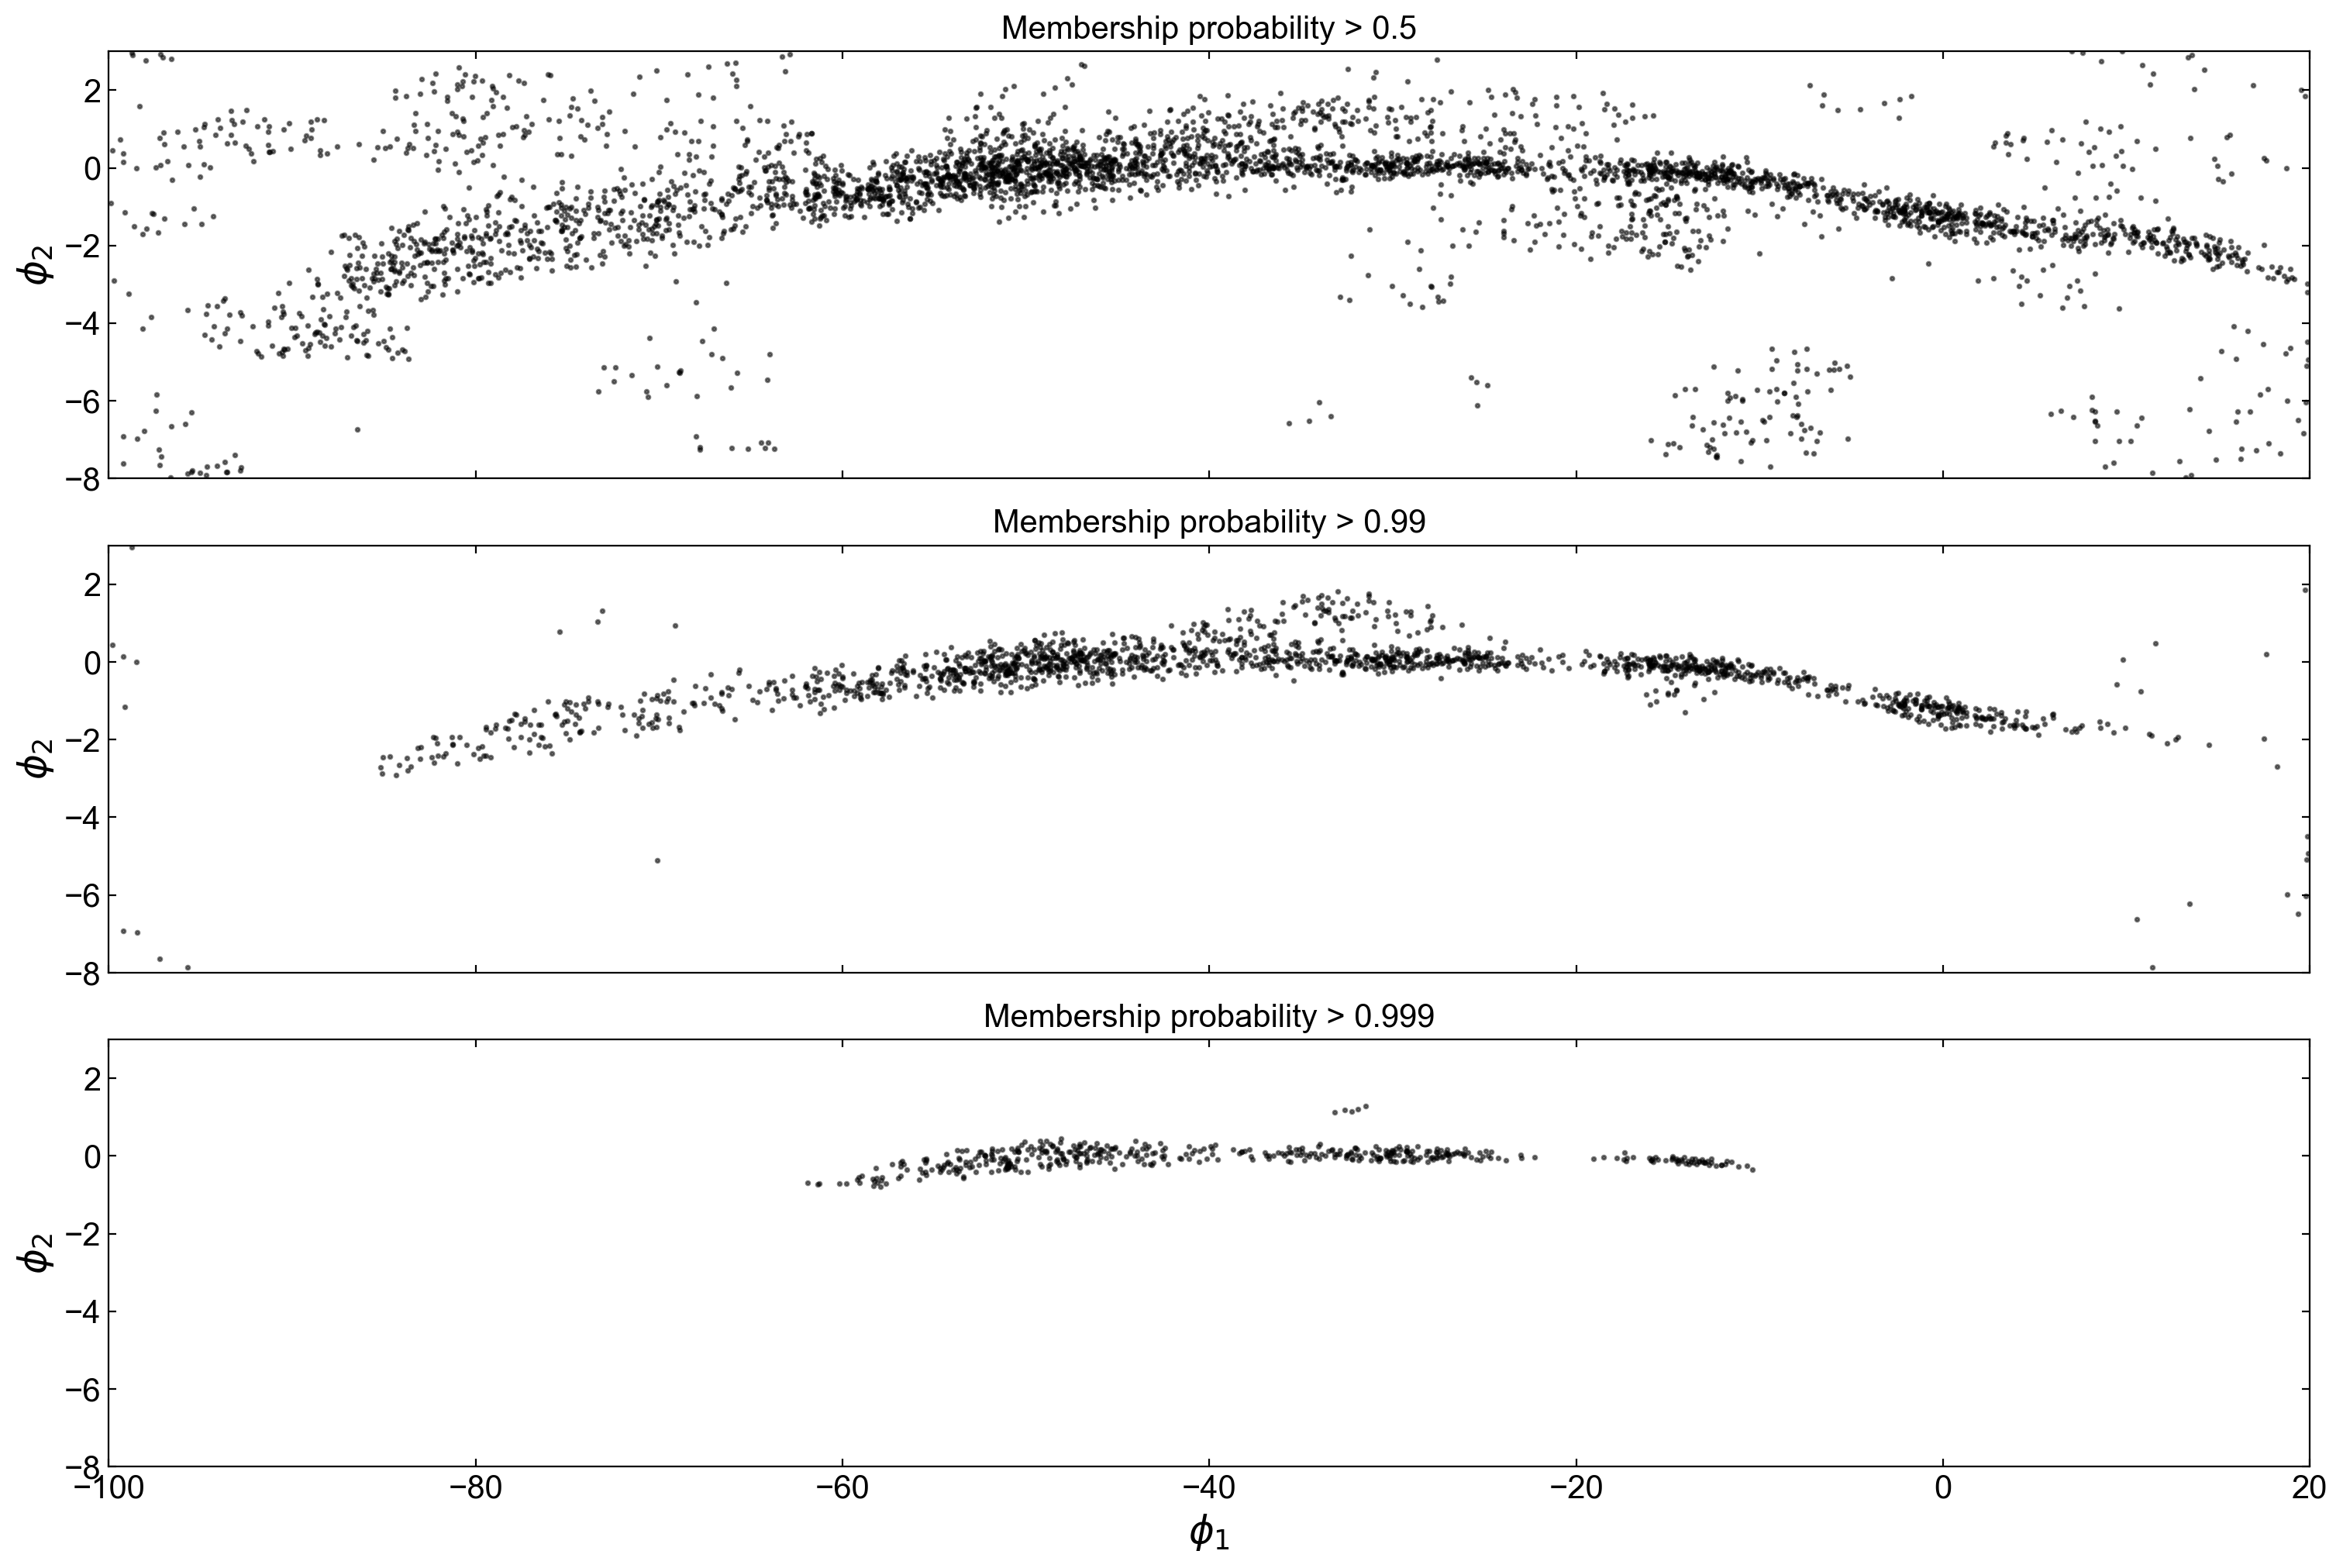

In [73]:
threshold1 = (final_memb_prob_all>0.5)
threshold2 = (final_memb_prob_all>0.9)
threshold3 = (final_memb_prob_all>0.99)

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(15, 10), constrained_layout=True, sharex=True, sharey=True)
im1 = ax1.scatter(most_cat['phi1'][threshold1], most_cat['phi2'][threshold1], c='k',
            s=3,alpha=0.5)
ax1.set_title('Membership probability > 0.5', fontsize=15)

ax2.scatter(most_cat['phi1'][threshold2], most_cat['phi2'][threshold2], c='k',
            s=3,alpha=0.5)
ax2.set_title('Membership probability > 0.99', fontsize=15)

ax3.scatter(most_cat['phi1'][threshold3], most_cat['phi2'][threshold3], c='k',
            s=3,alpha=0.5)
ax3.set_title('Membership probability > 0.999', fontsize=15)

ax3.set_xlim(-100, 20)
ax3.set_ylim(-8, 3)

ax3.set_xlabel(r"$\phi_1$", fontsize=18)
ax1.set_ylabel(r"$\phi_2$", fontsize=18)
ax2.set_ylabel(r"$\phi_2$", fontsize=18)
ax3.set_ylabel(r"$\phi_2$", fontsize=18)
# fig.suptitle('GD-1 Membership probabilities', fontsize=20)
plt.show()

### Create the distance-corrected CMD

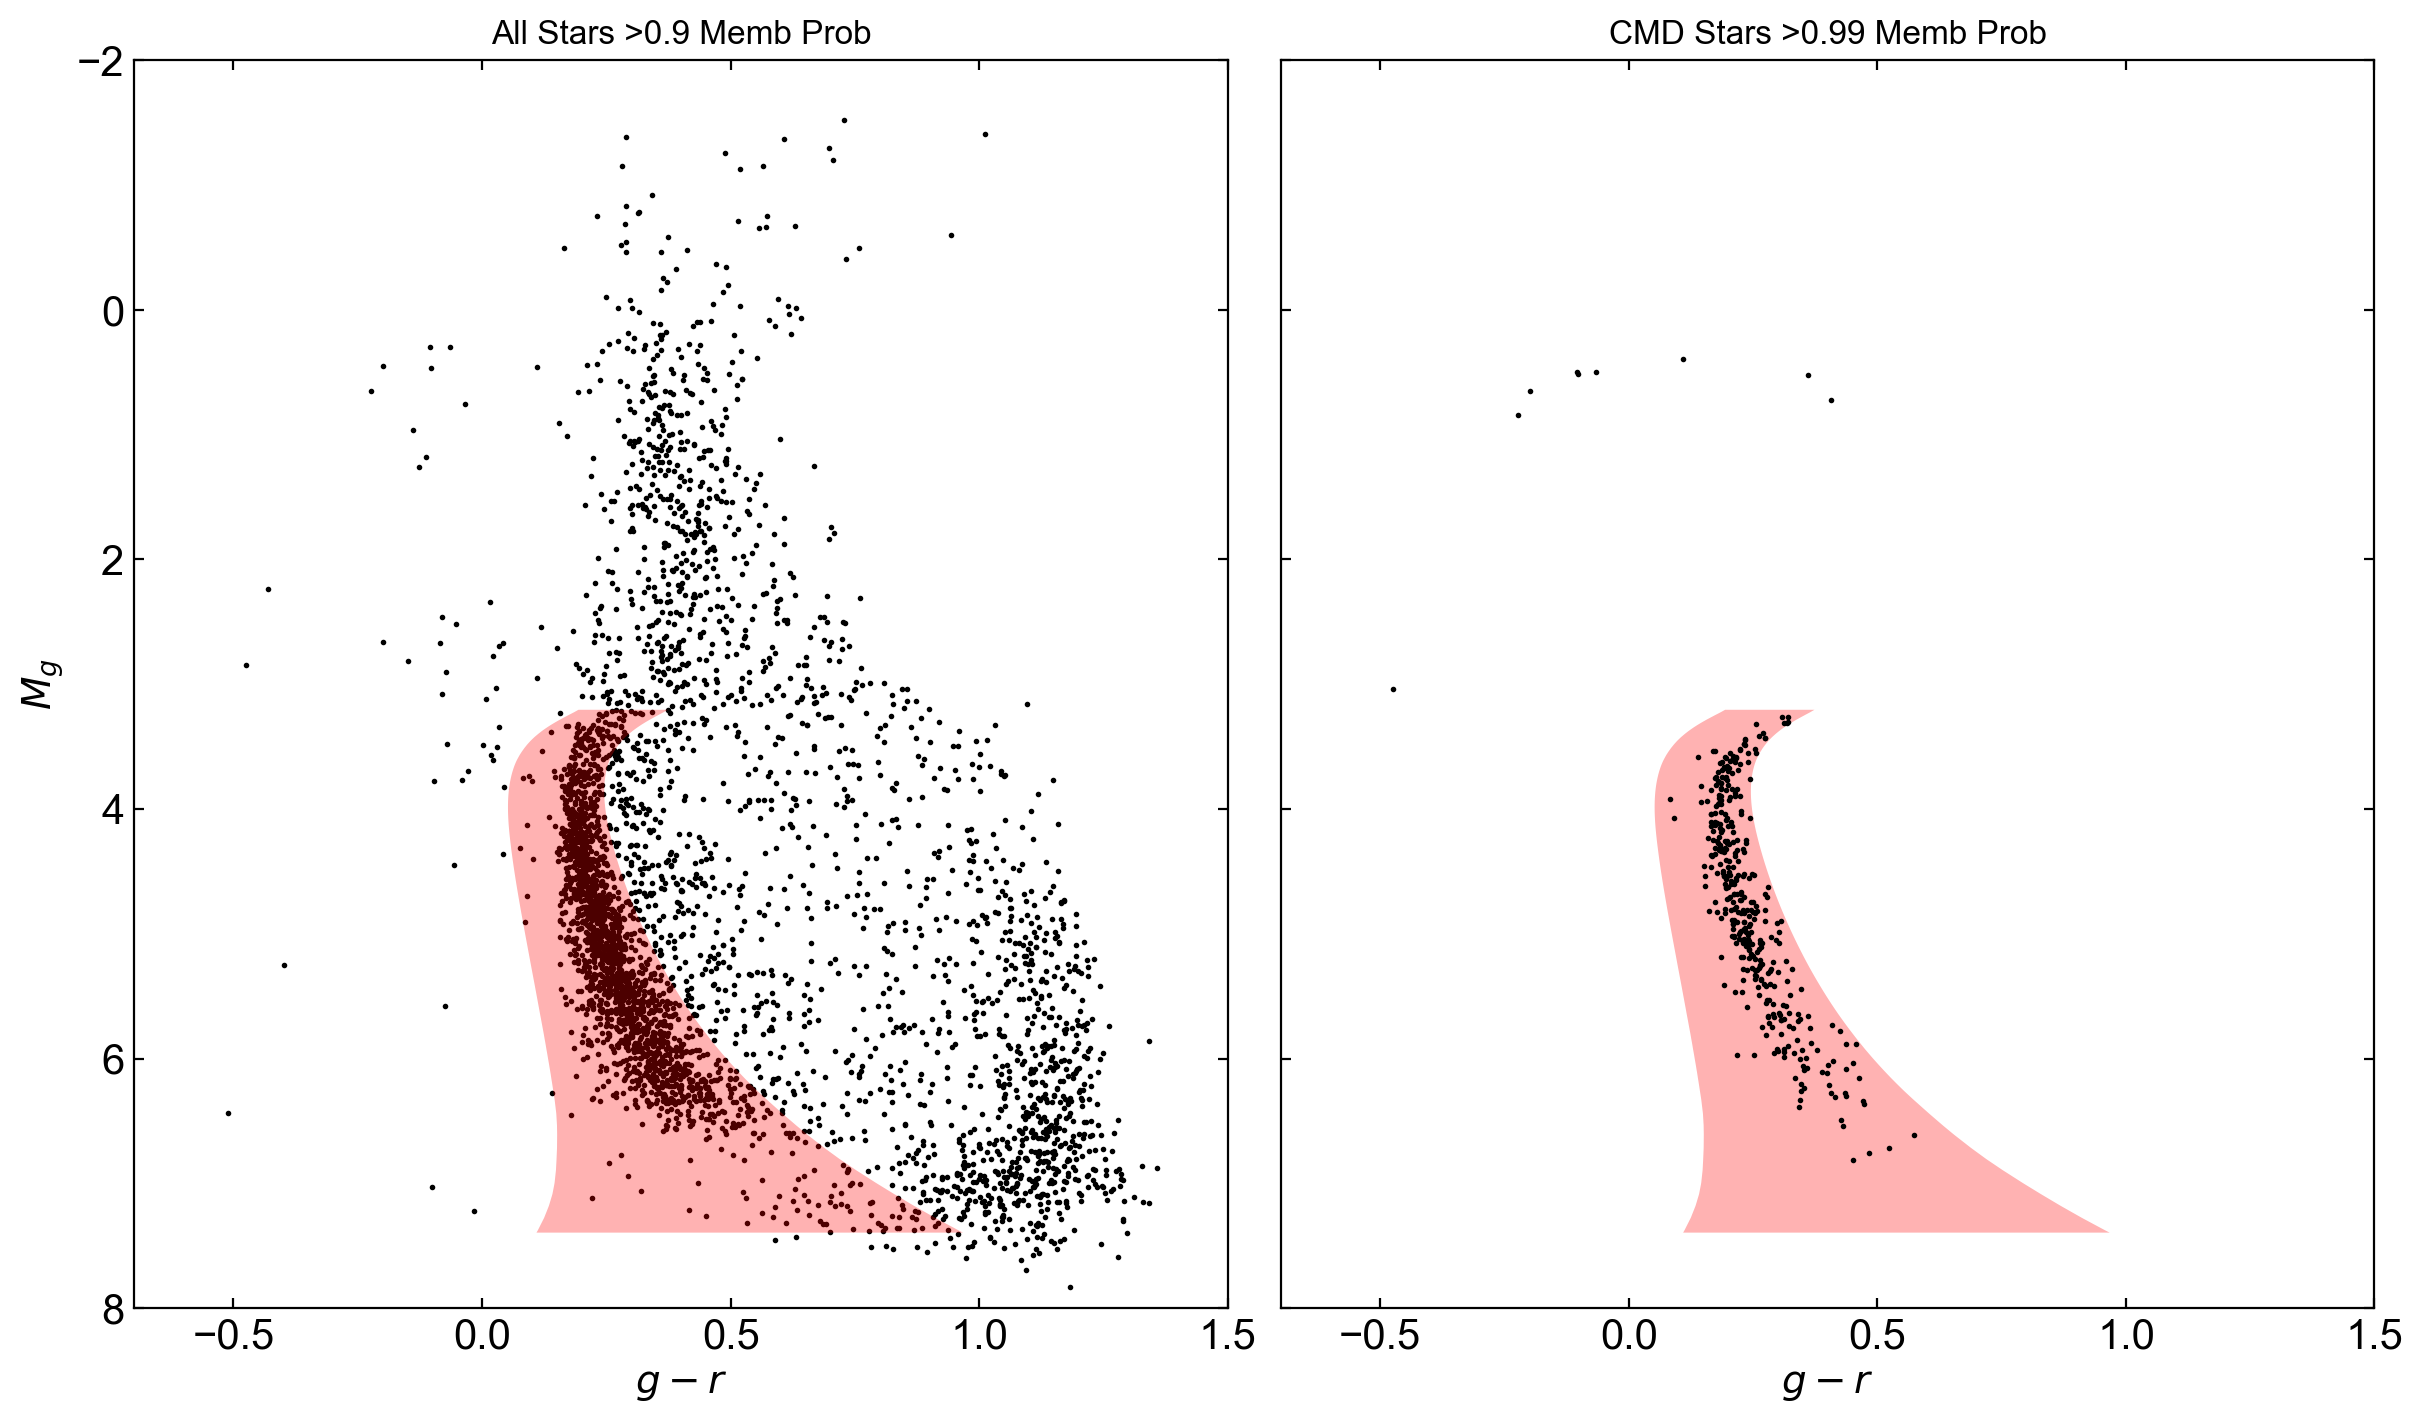

In [88]:
all_star_dat = most_cat_[final_memb_prob_all>0.5]
cmd_cut_dat = run_data_[final_memb_prob>0.99]

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(all_star_dat["phi1"]) - o.dist_mod
dist_mod_correct = distmod_spl(cmd_cut_dat["phi1"]) - o.dist_mod


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,7), sharey=True, sharex=True, constrained_layout=True)
ax1.scatter(all_star_dat['g0'] - all_star_dat['r0'], all_star_dat['g0'] - dist_mod_correct_all  - o.dist_mod, 
            c='k', s=1)
cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
ax1.add_patch(cmd_patch)
ax1.set_title('All Stars >0.9 Memb Prob')


cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
ax2.add_patch(cmd_patch)
ax2.scatter(cmd_cut_dat['g0'] - cmd_cut_dat['r0'], cmd_cut_dat['g0'] - dist_mod_correct  - o.dist_mod, 
            c='k', s=1)
ax2.set_title('CMD Stars >0.99 Memb Prob')

ax1.set_xlabel(r'$g-r$', fontsize=14)
ax2.set_xlabel(r'$g-r$', fontsize=14)
ax1.set_ylabel(r'$M_g$', fontsize=14)

ax1.set_xlim(-0.7, 1.5)
ax1.set_ylim(8, -2)
plt.show()

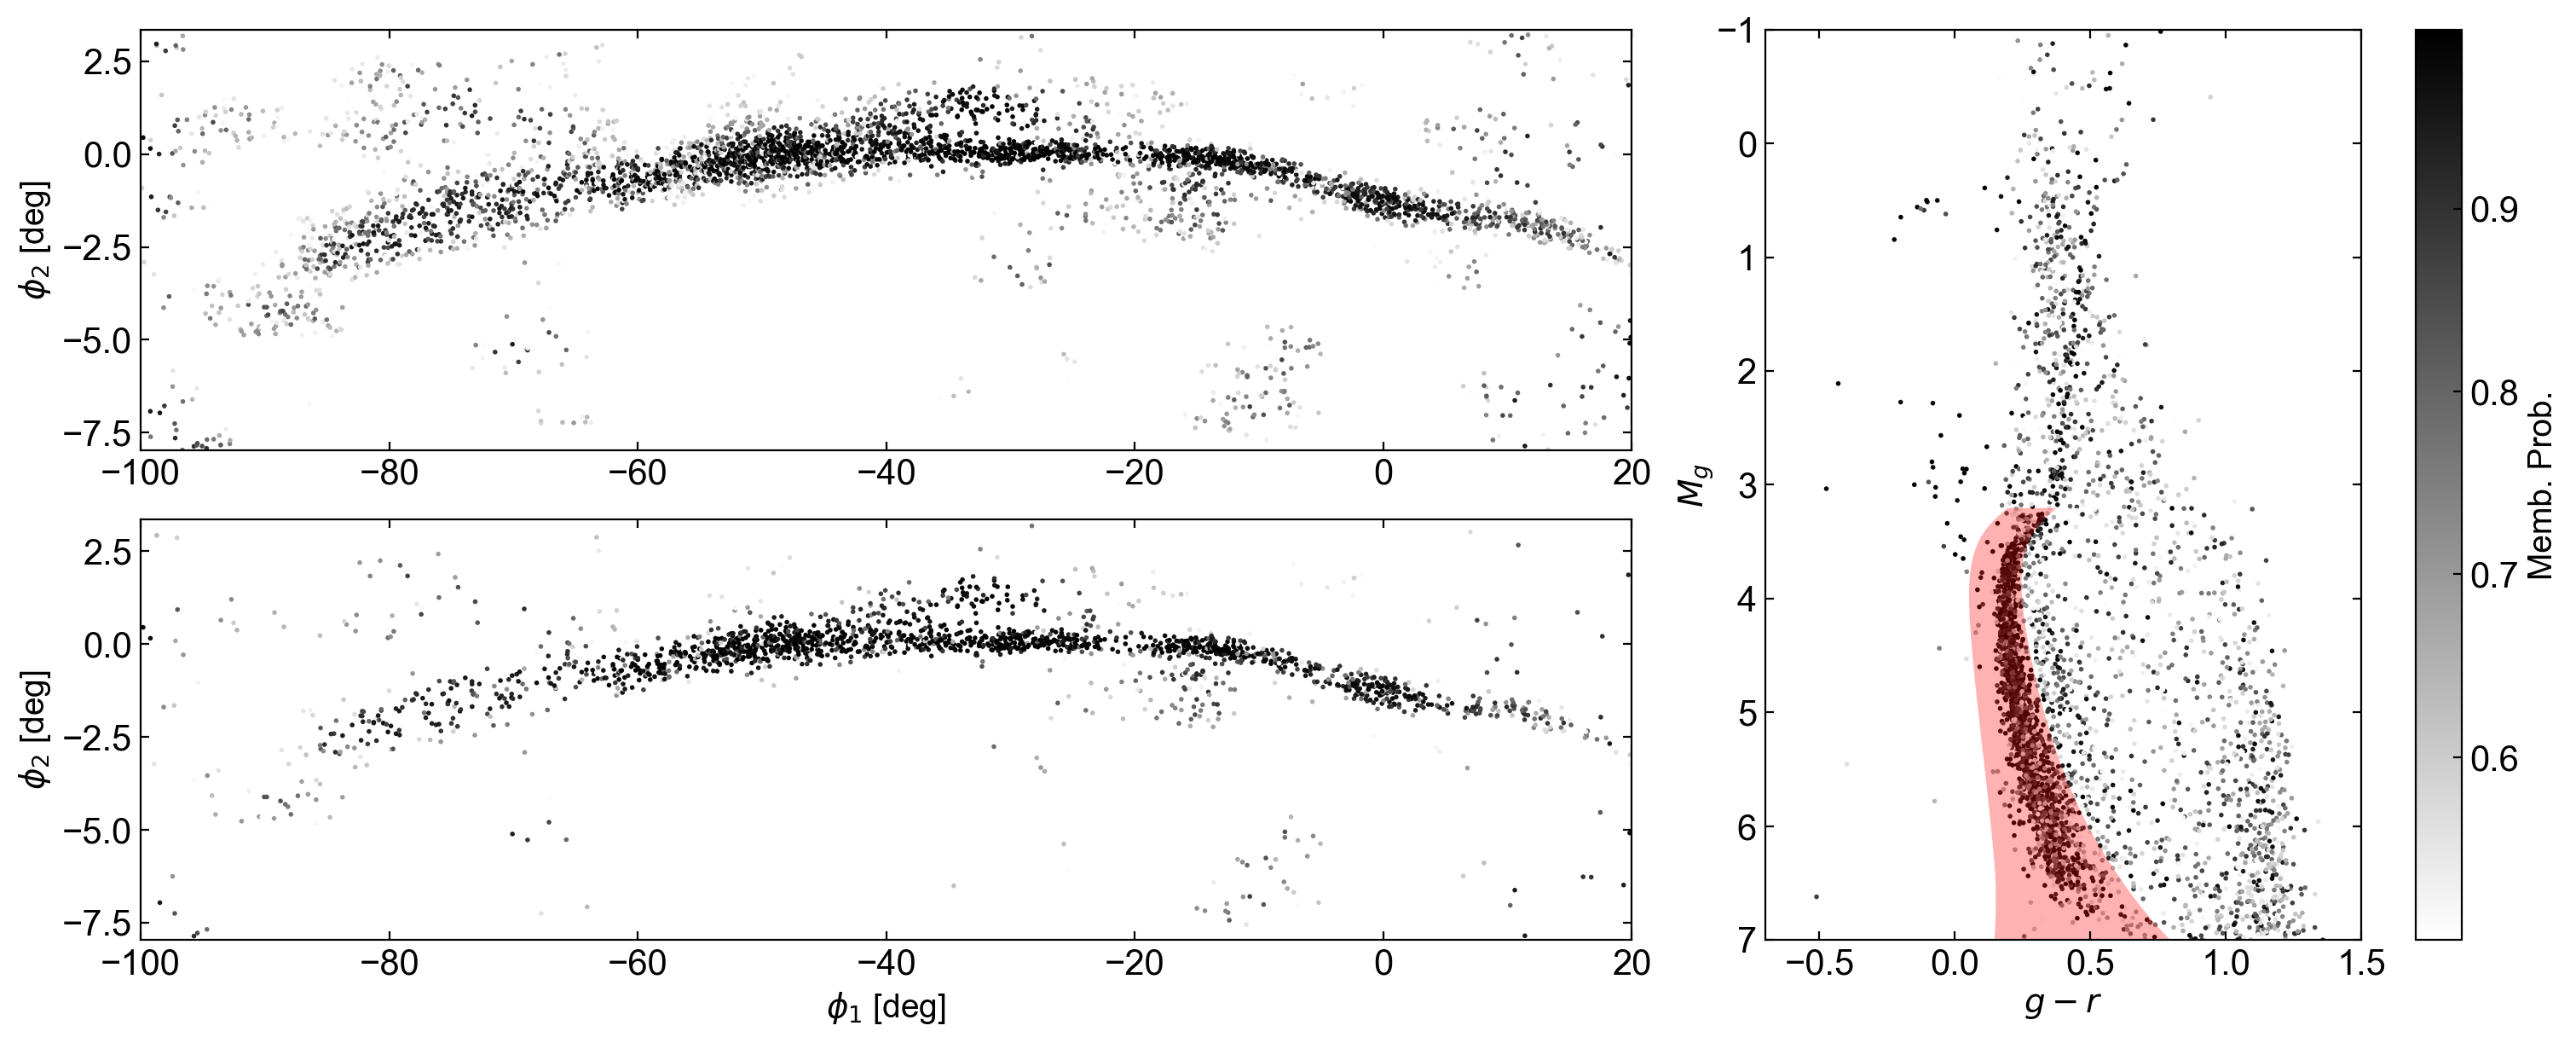

In [102]:
cut_all = final_memb_prob_all>0.5
plot_data_all = most_cat_[cut_all]
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(plot_data_all["phi1"]) - o.dist_mod
plot_probs_all = final_memb_prob_all[cut_all]

c_map = cmr.eclipse_r
c_map='gray_r'

cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)

fig = plt.figure(figsize=(15,6), layout="constrained")
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 0.4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:,1])

im1 = ax1.scatter(plot_data_all['phi1'], plot_data_all['phi2'], c=plot_probs_all,
            s=1, cmap=c_map)
# ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax1.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax1.set_xlim(-100, 20)
ax1.set_ylim(Base.coord_bounds['phi2'][0], Base.coord_bounds['phi2'][1])

im2 = ax2.scatter(plot_data['phi1'], plot_data['phi2'], c=plot_probs,
            s=1, cmap=c_map)
ax2.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax2.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax2.set_xlim(-100, 20)
ax2.set_ylim(Base.coord_bounds['phi2'][0], Base.coord_bounds['phi2'][1])

im3 = ax3.scatter(plot_data_all['g0'] - plot_data_all['r0'], plot_data_all['g0'] - dist_mod_correct_all - o.dist_mod, 
                  c=plot_probs_all, cmap=c_map, s=1)
ax3.add_patch(cmd_patch)
ax3.set_xlim(-0.7, 1.5)
ax3.set_ylim(7, -1)
ax3.set_xlabel(r"$g-r$", fontsize=14)
ax3.set_ylabel(r"$M_g$", fontsize=14, labelpad=0.1)

cbar = fig.colorbar(im3, ax=ax3)
cbar.set_label('Memb. Prob.', fontsize=14)
# plt.savefig('../paper_figures/high_prob_members.pdf')
plt.show()

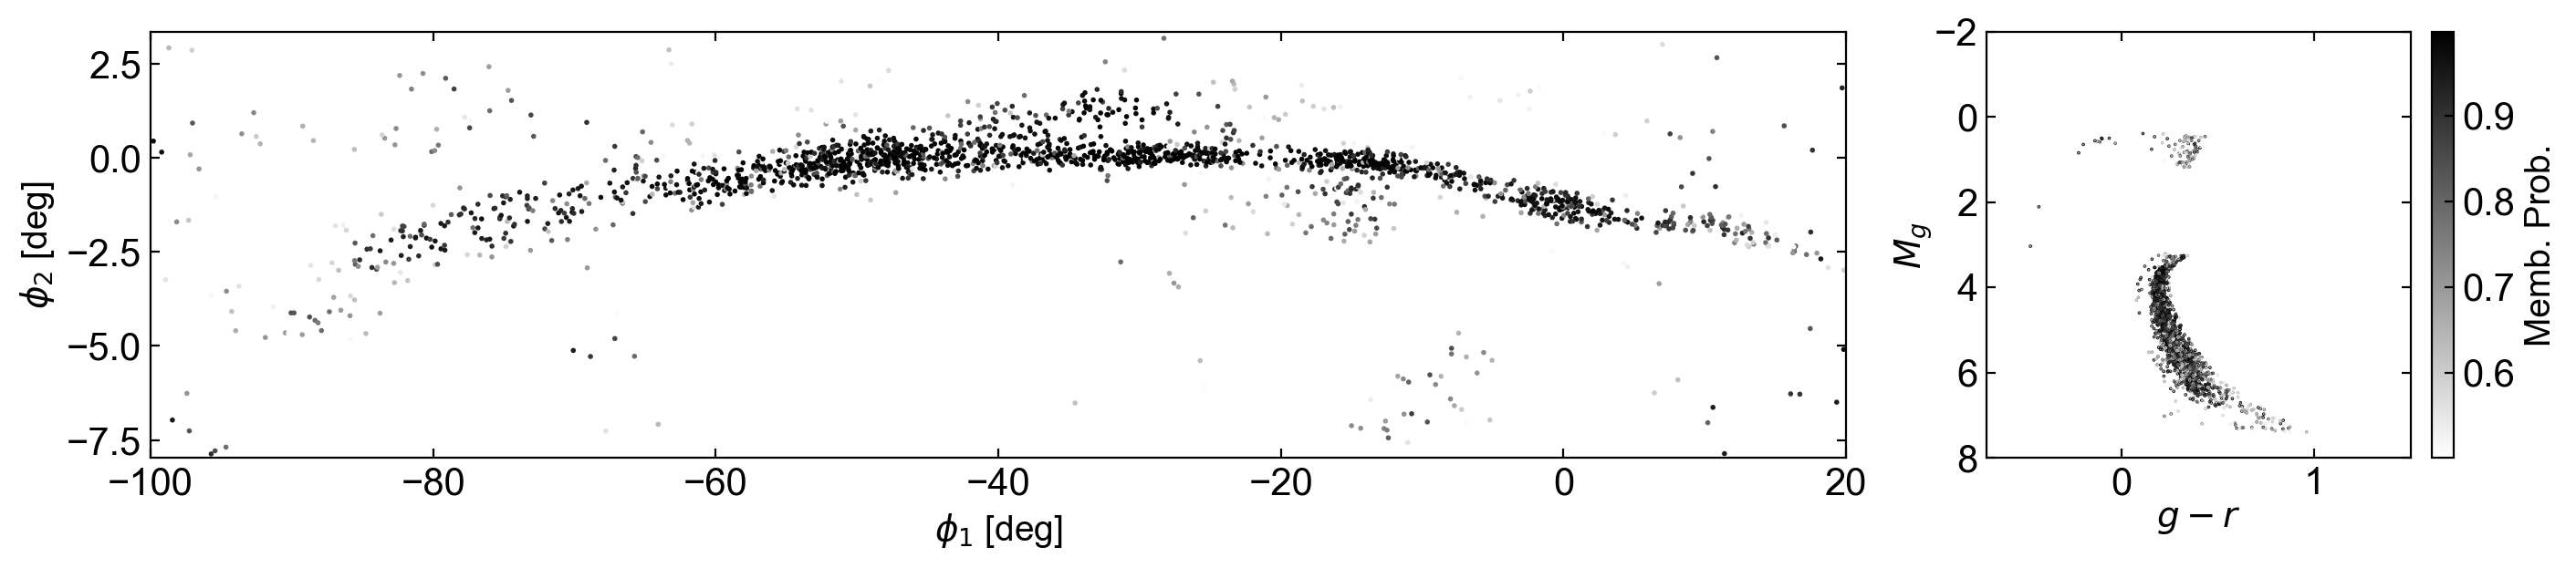

In [75]:
cut = final_memb_prob>0.5
plot_data = run_data_[cut]
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct = distmod_spl(plot_data["phi1"]) - o.dist_mod
plot_probs = final_memb_prob[cut]

c_map = cmr.eclipse_r
c_map = 'gray_r'

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14,3), width_ratios=[1,0.25], constrained_layout=True)

im1 = ax1.scatter(plot_data['phi1'], plot_data['phi2'], c=plot_probs,
            s=1, cmap=c_map)
ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=14)
ax1.set_ylabel(r"$\phi_2$ [deg]", fontsize=14)
ax1.set_xlim(-100, 20)
ax1.set_ylim(Base.coord_bounds['phi2'][0], Base.coord_bounds['phi2'][1])

im2 = ax2.scatter(plot_data['g0'] - plot_data['r0'], plot_data['g0'] - dist_mod_correct - o.dist_mod, c=plot_probs, 
            cmap=c_map, s=0.1)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)
ax2.set_xlabel(r"$g-r$", fontsize=14, labelpad=0.5)
ax2.set_ylabel(r"$M_g$", fontsize=14, labelpad=0.1)

cbar = fig.colorbar(im2, ax=ax2)
cbar.set_label('Memb. Prob.', fontsize=14)
# plt.savefig('../paper_figures/high_prob_members.pdf')
plt.show()

In [72]:
run_data_.write('gd1_memb_prob_post_CMD_cut.fits', overwrite=True)
most_cat_.write('gd1_memb_prob_all.fits', overwrite=True)